### https://www.youtube.com/watch?v=Cf6QFjdU_KY

## Audio Import & ChecK

In [13]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

C:\Users\82108\AppData\Local\Temp\ipykernel_8376\2006894712.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [9]:
midi_file = "../../GeneralMidi.wav"

In [10]:
sec = 2
num_notes = 50
audio = []
inst = []

for inst_idx, note in itertools.product(range(128), range(num_notes)):
    instrument = inst_idx
    offset = (instrument*num_notes*sec) + (note*sec)
    #print(f"instrument: {instrument}, note: {note}, offset: {offset}")
    y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
    audio.append(y)
    inst.append(inst_idx)

In [11]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape, inst_np.shape)

(6400, 88200) (6400,)


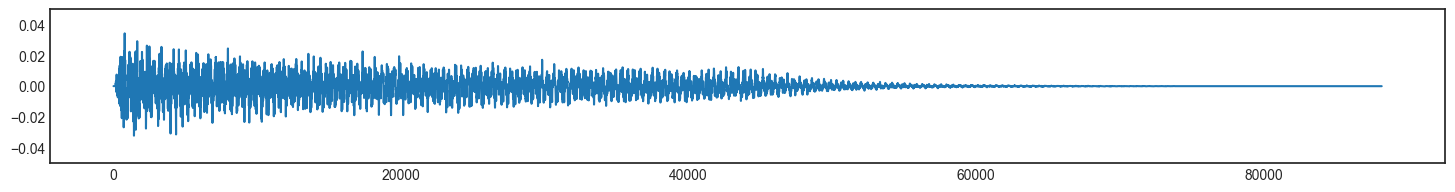

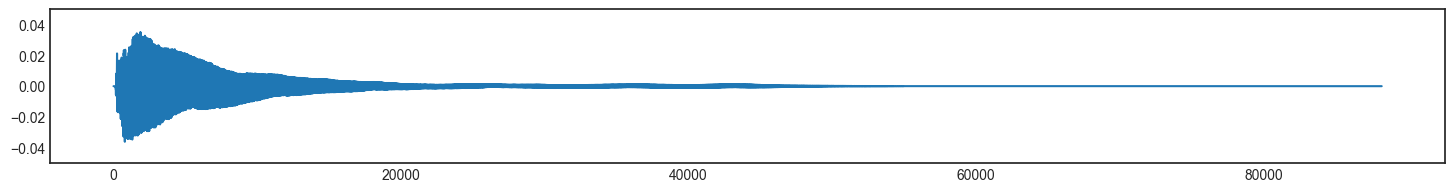

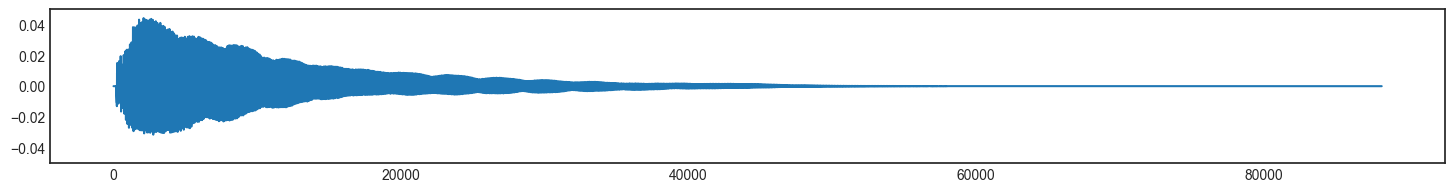

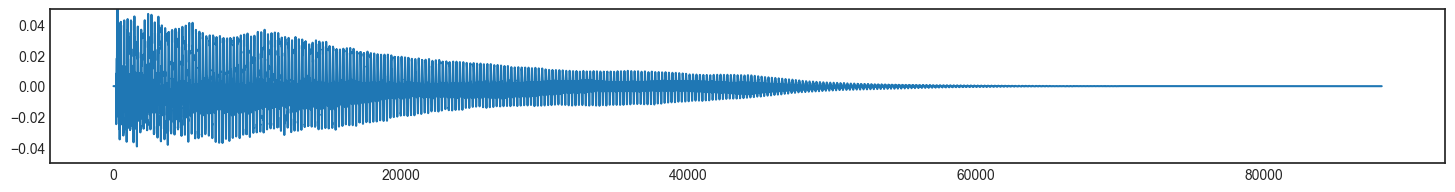

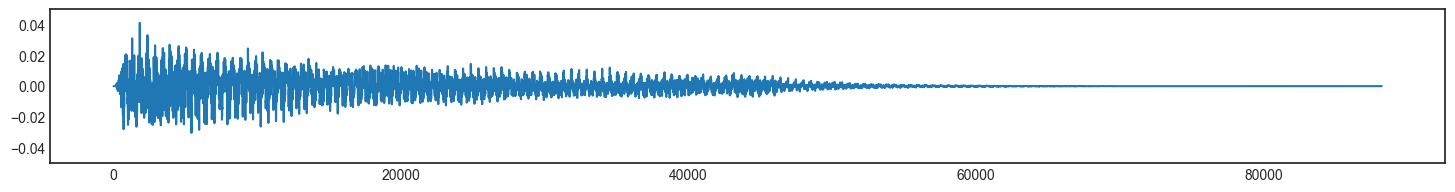

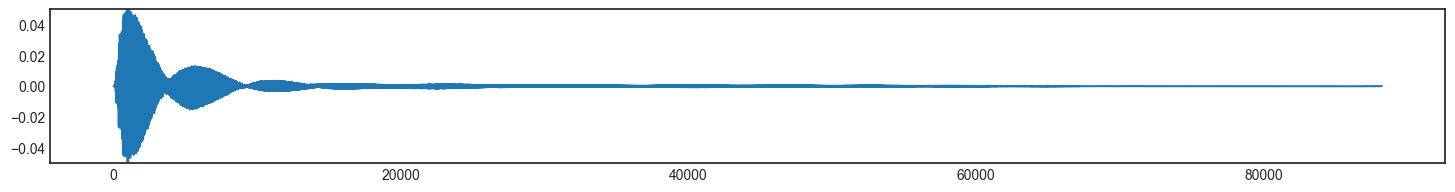

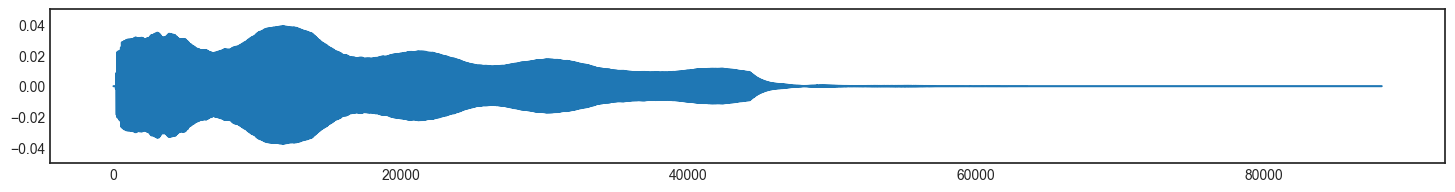

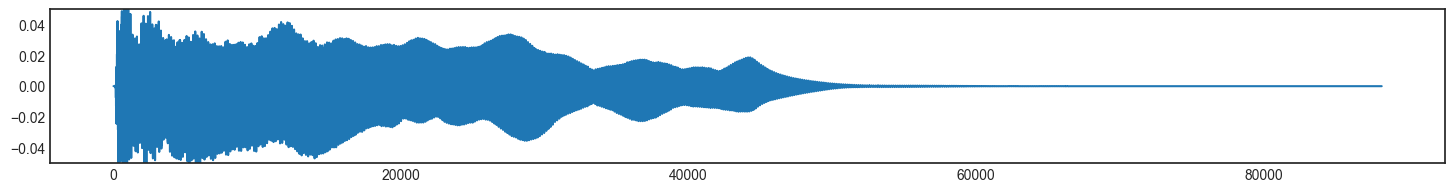

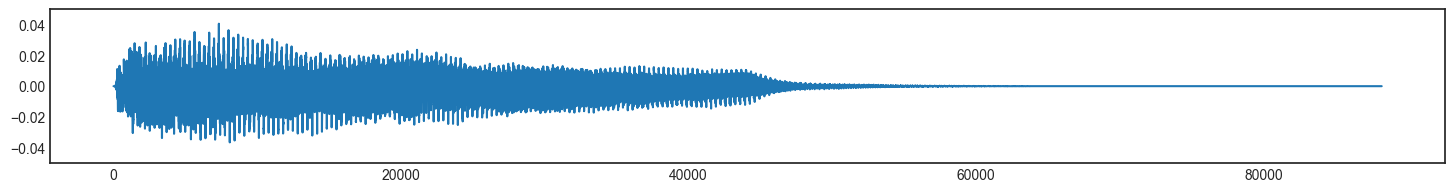

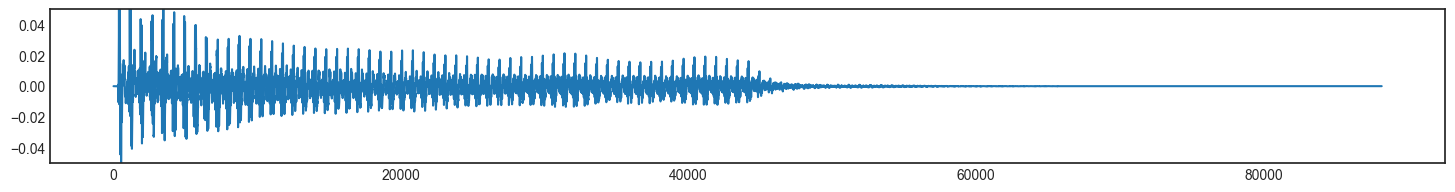

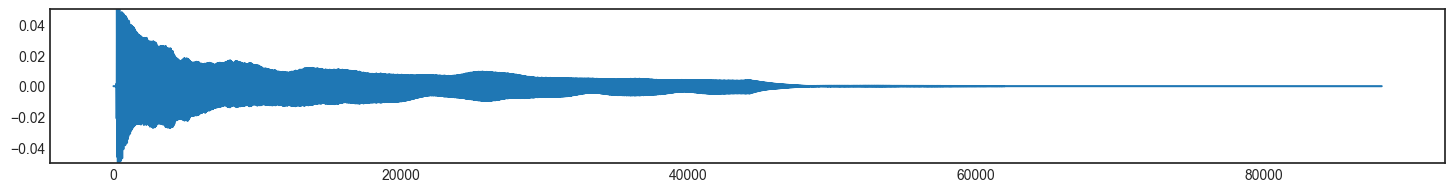

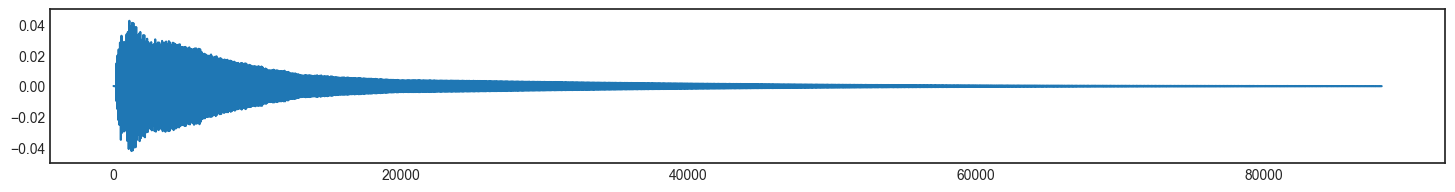

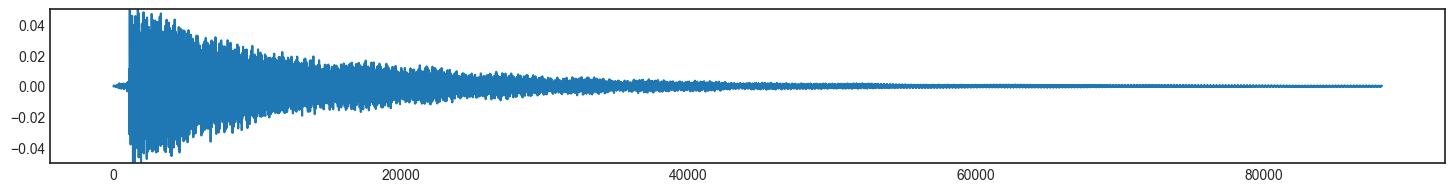

In [14]:
for idx in range(0, len(audio_np)//10, num_notes):
    plt.figure(figsize=(18,2))
    plt.plot(audio_np[idx])
    plt.ylim((-0.05, 0.05))
    plt.show()

In [ ]:
print(inst_np[1])
ipd.Audio(audio_np[1], rate=sr)

In [ ]:
print(inst_np[901])
ipd.Audio(audio_np[901], rate=sr)

In [15]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(5120, 88200)
(1280, 88200)
(5120,)
(1280,)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)

pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

## SVM

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)

print(acc)

## Constant-Q를 이용한 ML 오디오 분류
- wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기엔 적합하지 않음. (음악 감상은 음의 높이와 세기를 듣는것이지, 그 순간의 음압을 듣는 것이 아니기 떄문)
- 푸리에 변환과 같은 변환 기법을 사용하여 시간 축의 데이터(Time Domain)를 주파수 축의 데이터(Frequancy Domain)로 바꿔줘야할 필요가 있음.
- 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
- Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되어 음악을 처리하는데에 푸리에 변환보다 유리
- CQT 기반의 스펙트럼 분석은 낮은 주파수 영역에서는 좁은 대역폭을 가지고, 높은 주파수 영역에서는 넓은 대역폭을 가짐. (인간의 청력은 낮은 주파수에 더 민감하기 때문에 낮은 주파수 대역에서 고해상도로 분석하는 것이 효과적, 현실적)

- Constant-Q 변환할 때는 변환할 오디오 데이터와 Sampling Rate가 필요

※ 참고 
- https://heeya-stupidbutstudying.tistory.com/entry/DL-%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%9D%8C%EC%84%B1-%EC%9D%B4%ED%95%B4-Introduction-to-sound-data-analysis#google_vignette

In [16]:
"""
n_bins = 옥타브 단계 및 개수
bins_per_octave = 한 옥타브가 가지는 단계 의미
라벨은 원 핫 인코딩 적용
"""

audio_cqt = []
for y in audio:
    ret = librosa.cqt(y=y, sr=sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
    ret = np.abs(ret)
    audio_cqt.append(ret)

C:\Users\82108\AppData\Local\Temp\ipykernel_8376\954433559.py:7: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(data=amp_db, sr=sr, x_axis='time', y_axis='cqt_note')


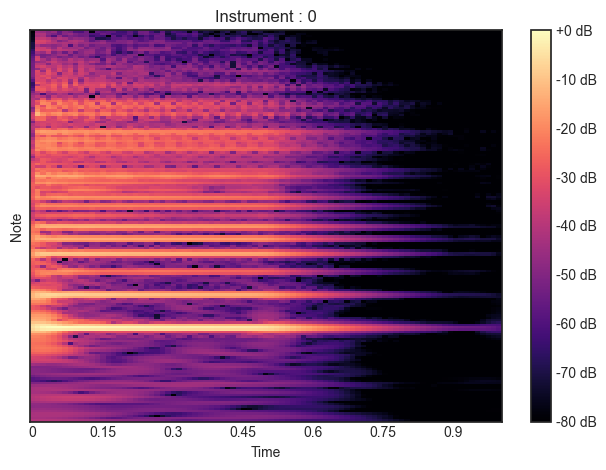

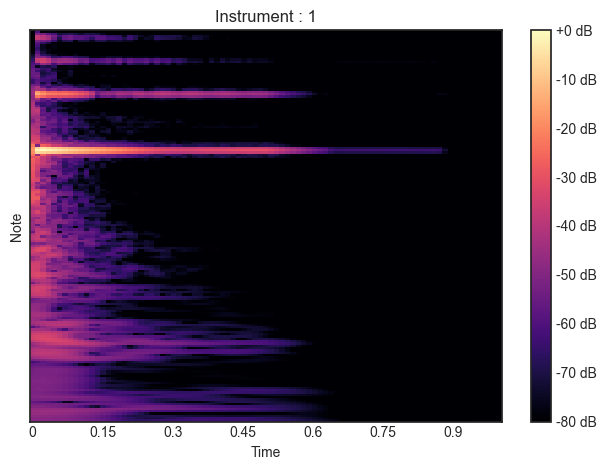

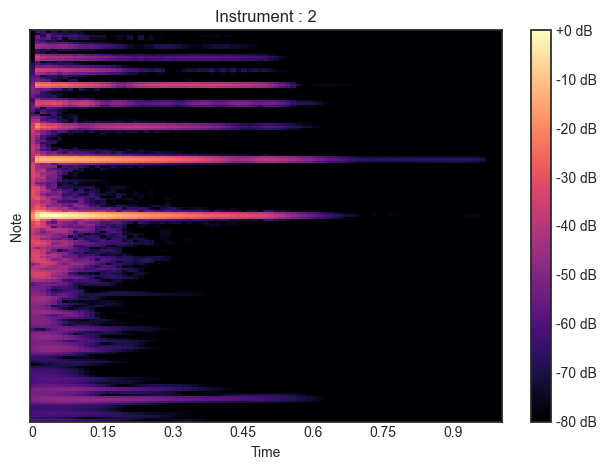

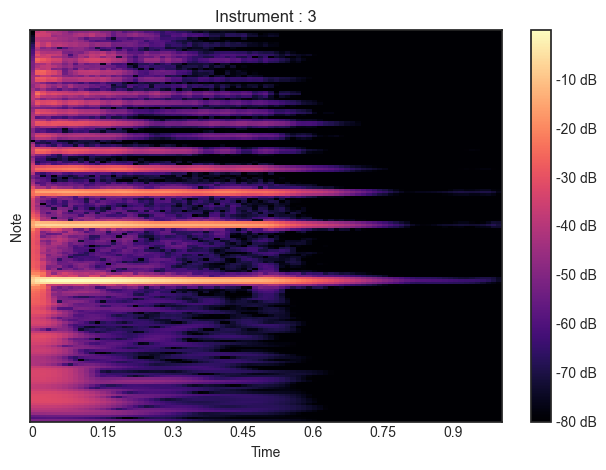

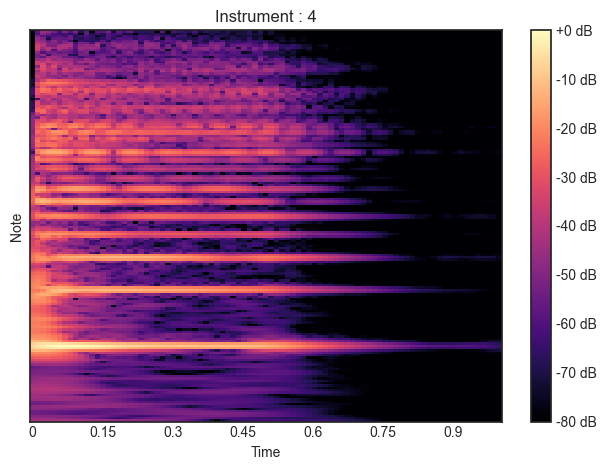

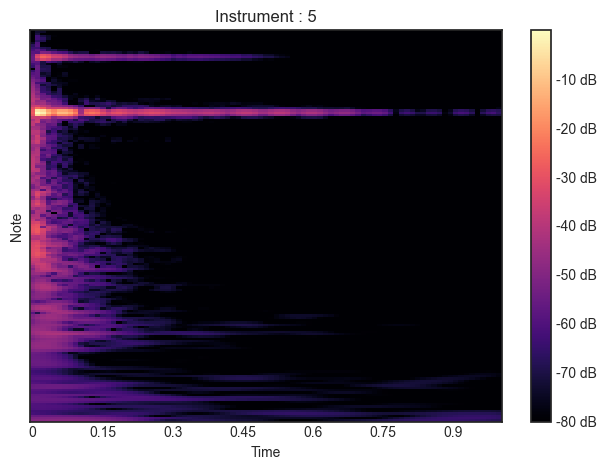

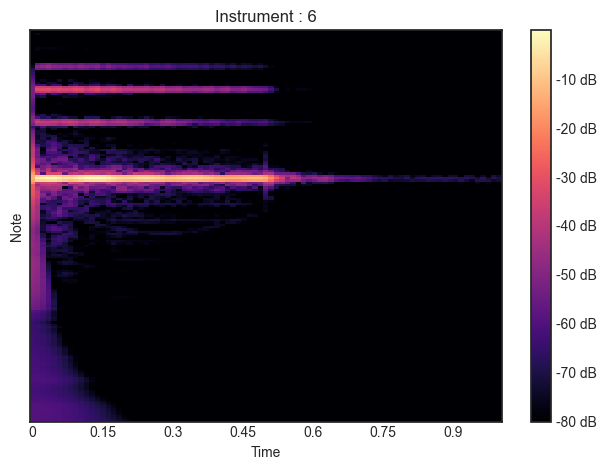

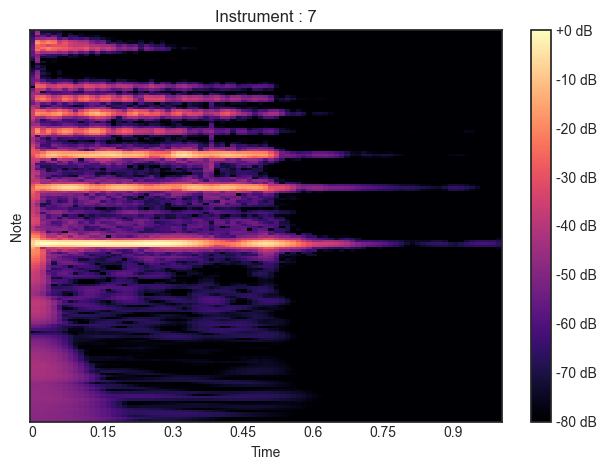

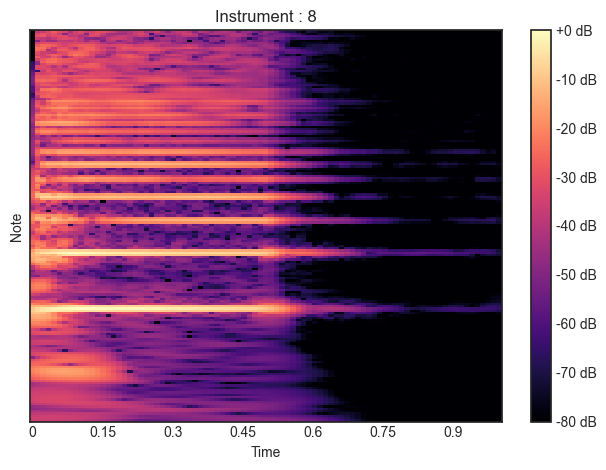

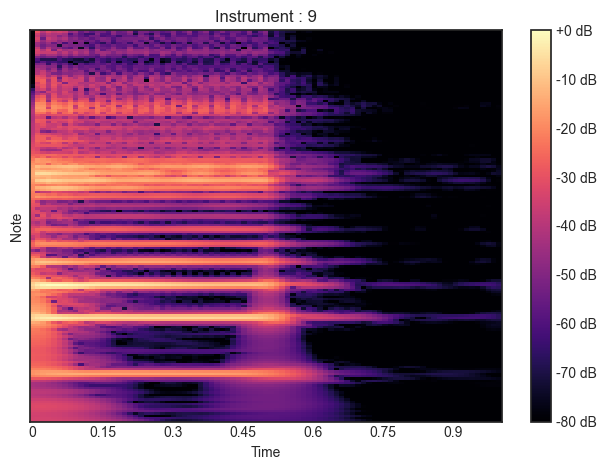

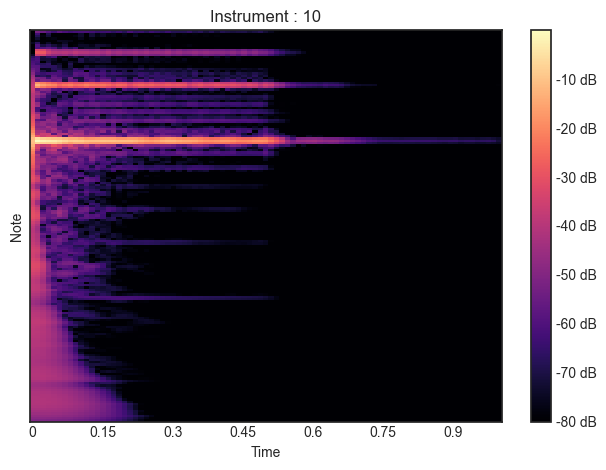

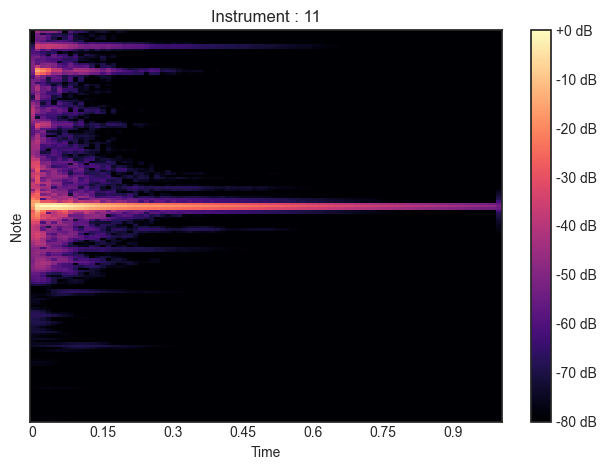

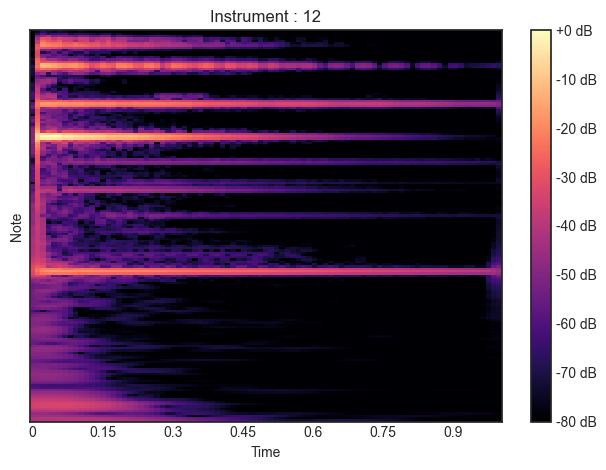

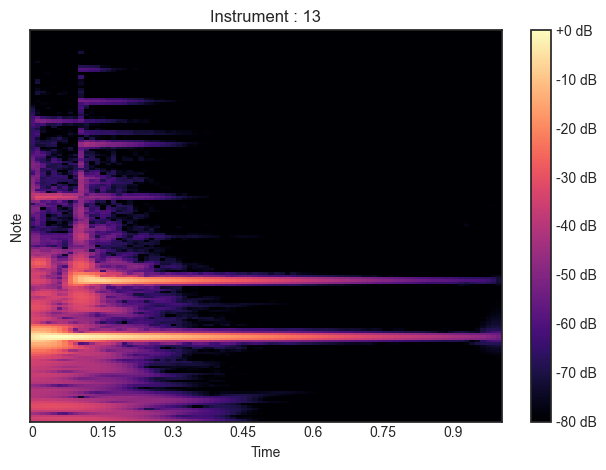

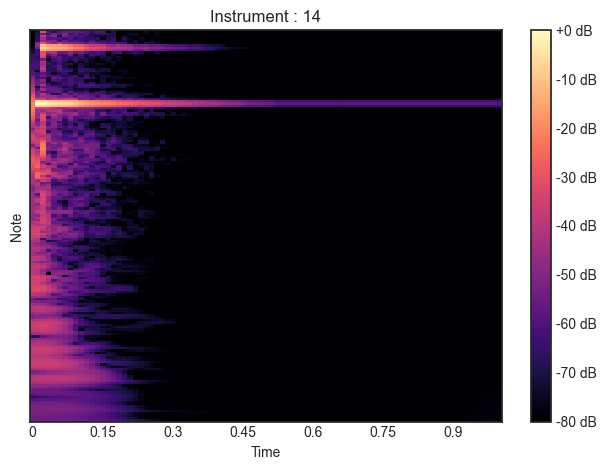

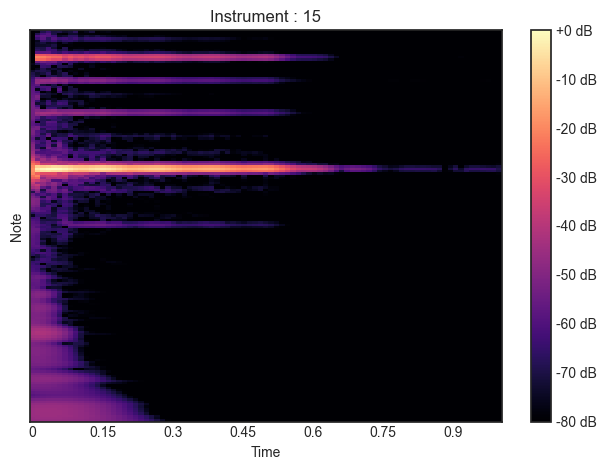

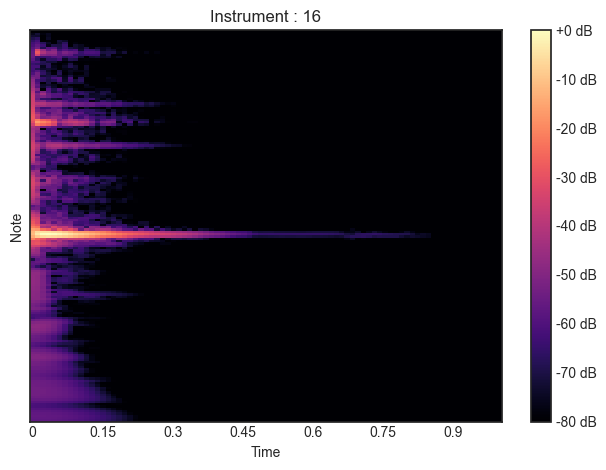

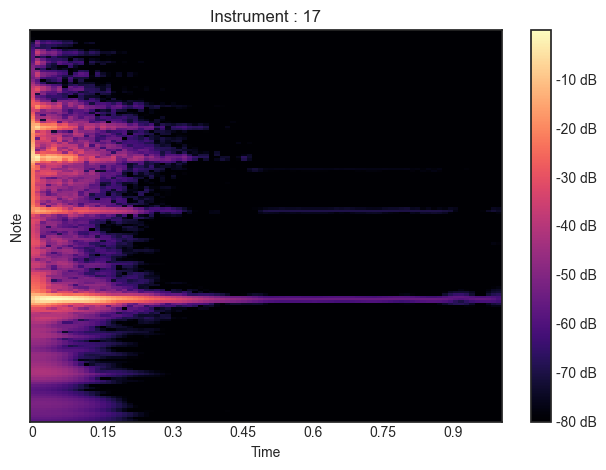

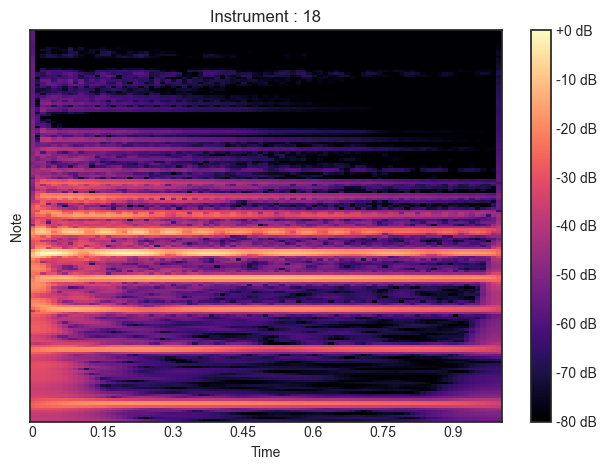

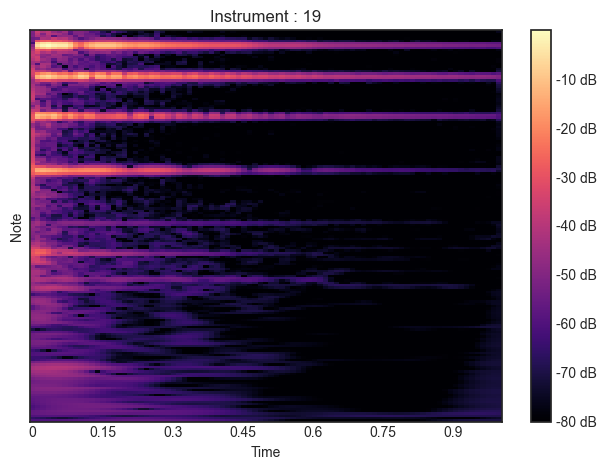

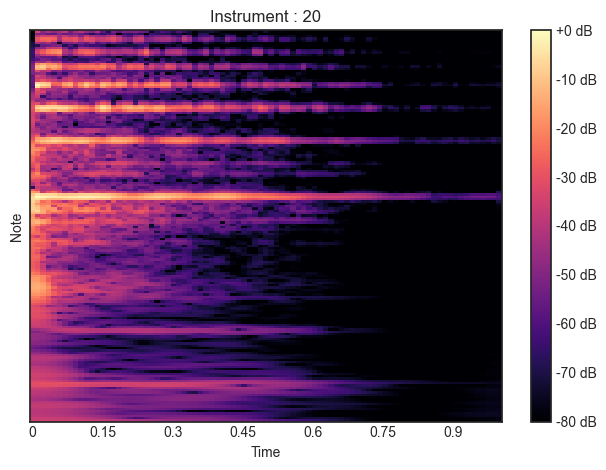

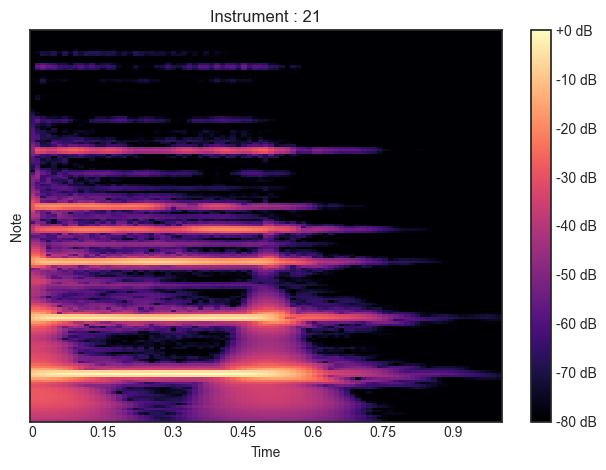

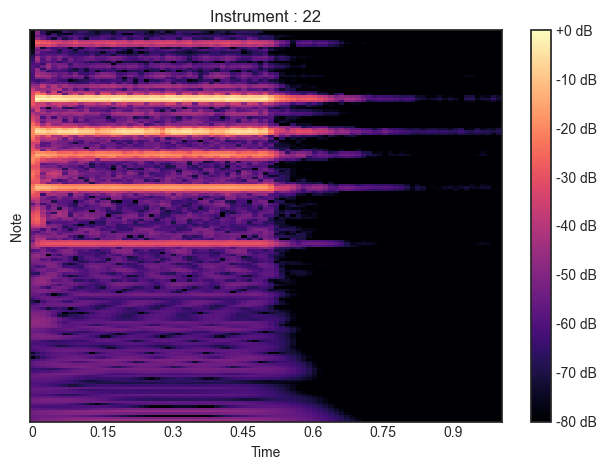

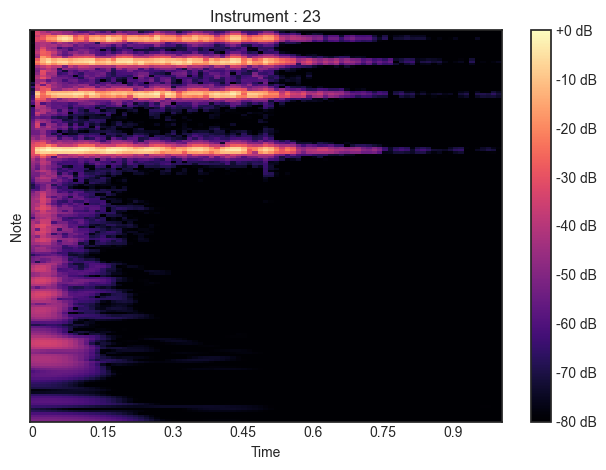

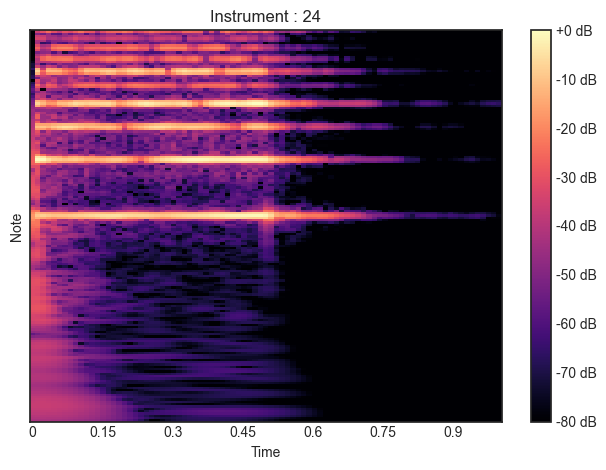

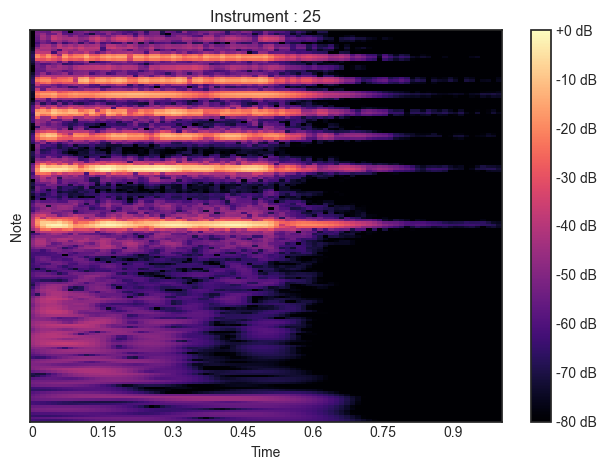

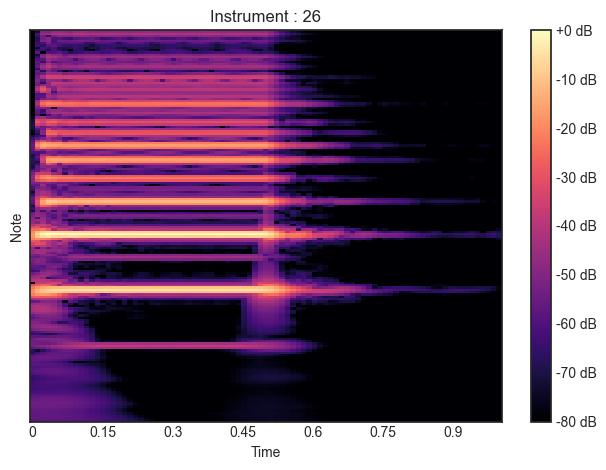

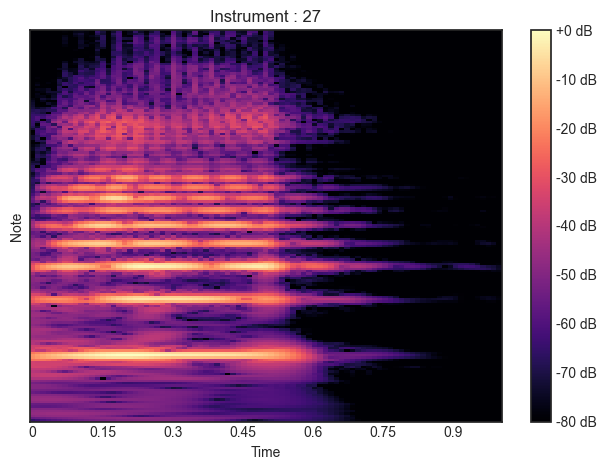

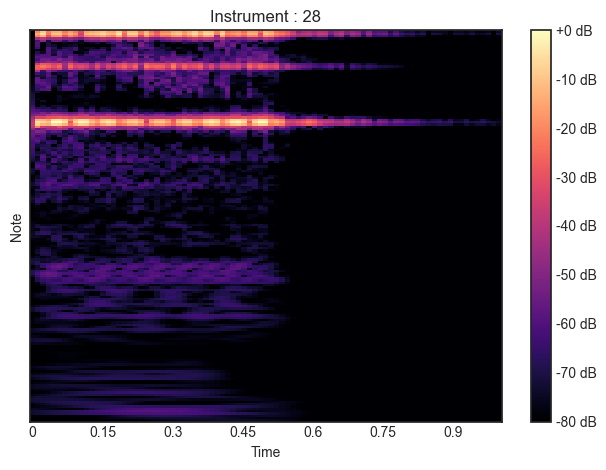

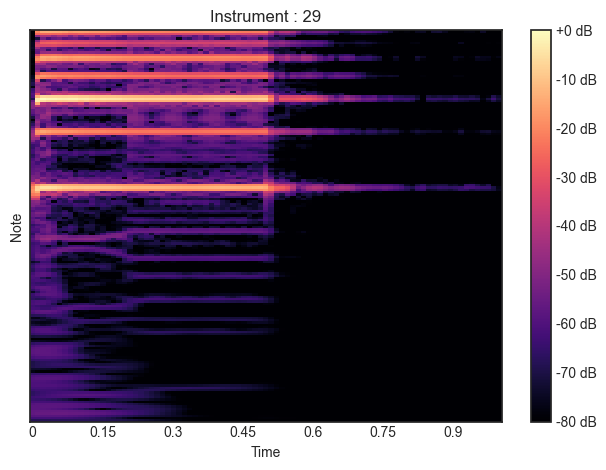

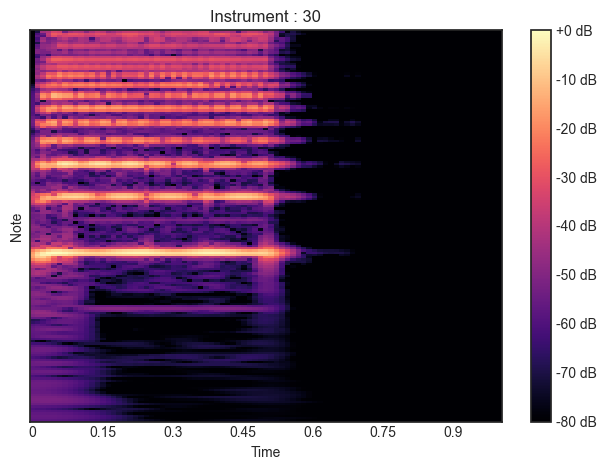

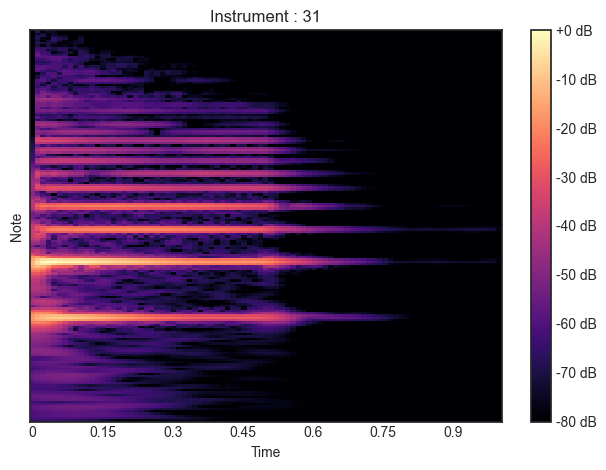

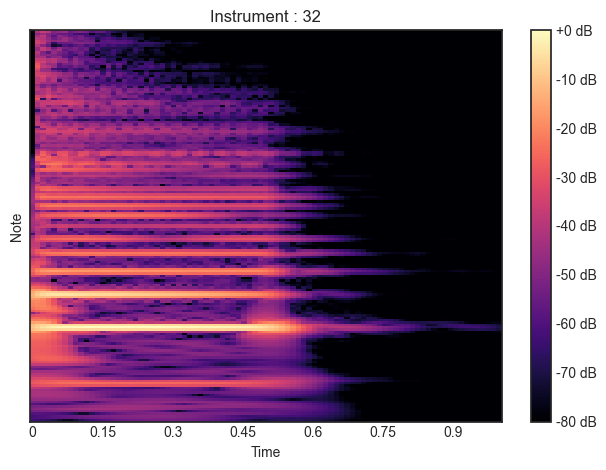

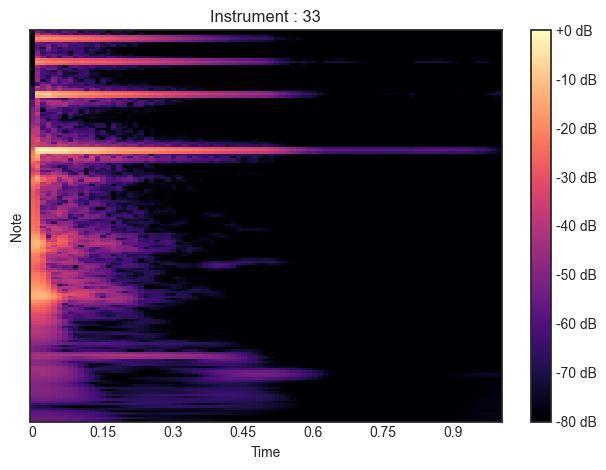

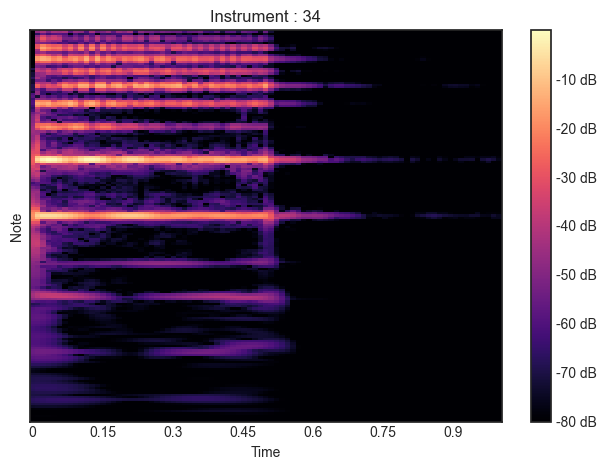

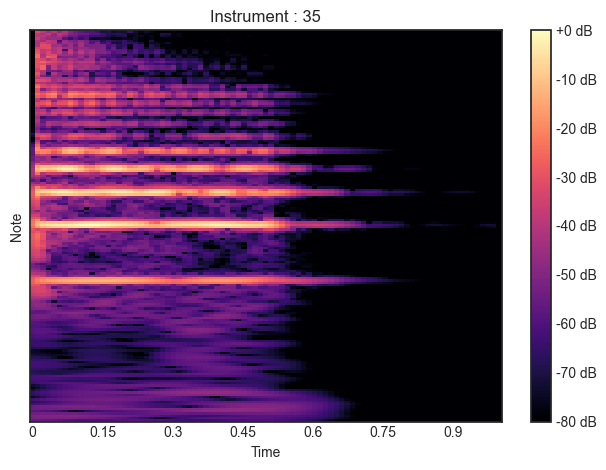

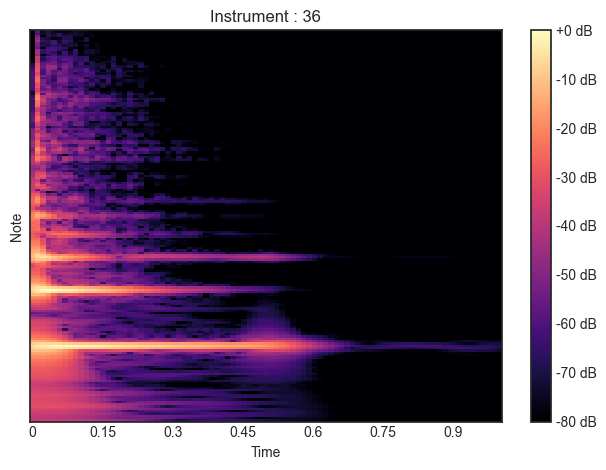

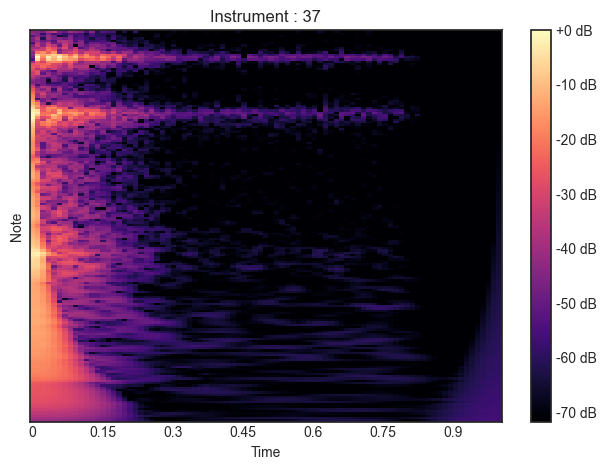

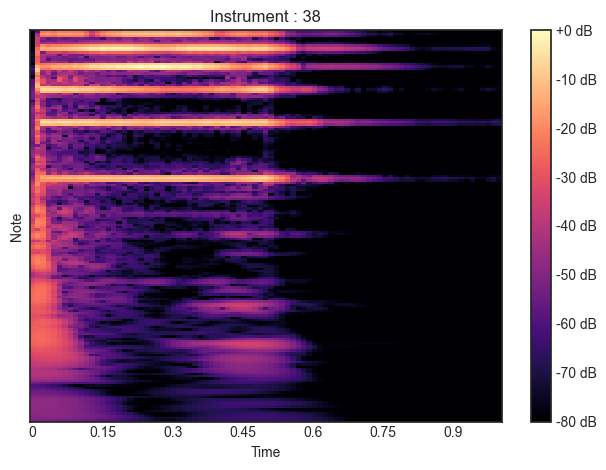

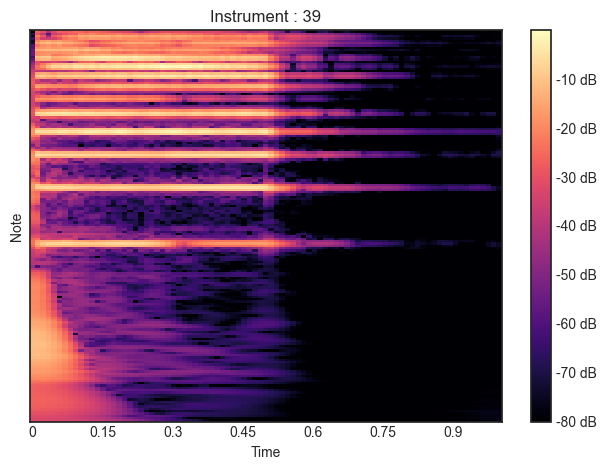

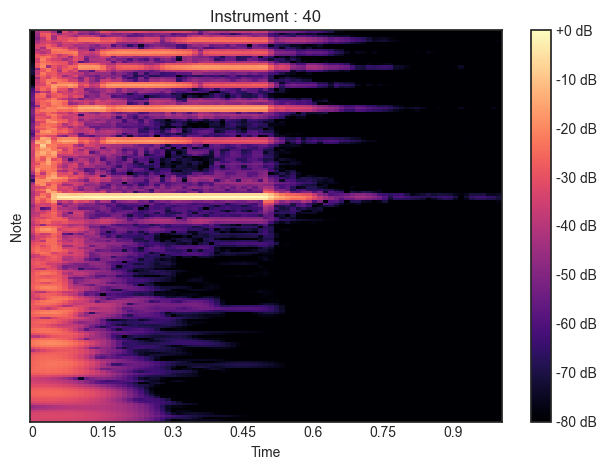

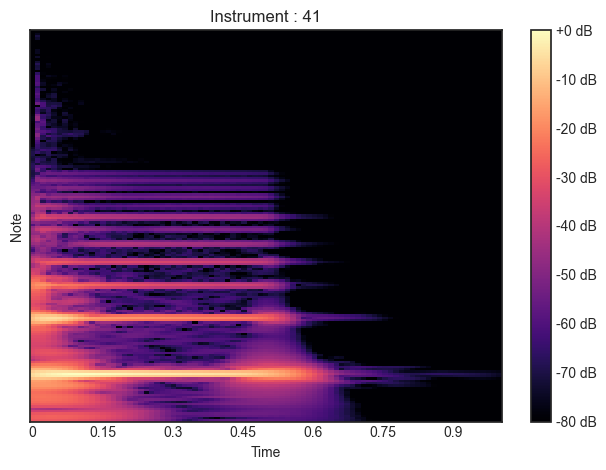

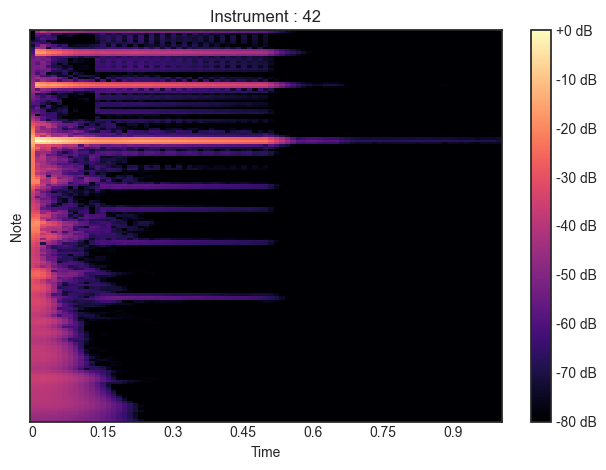

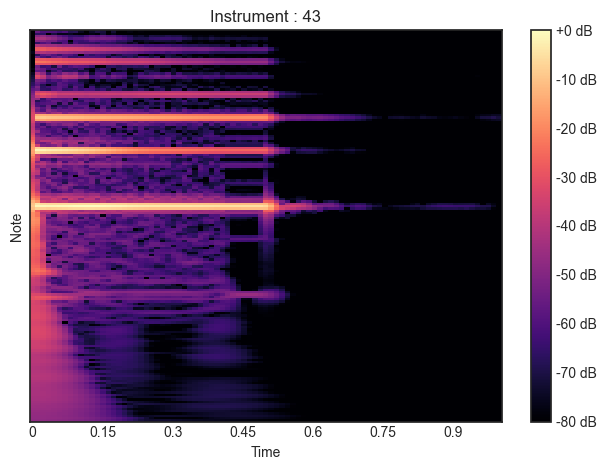

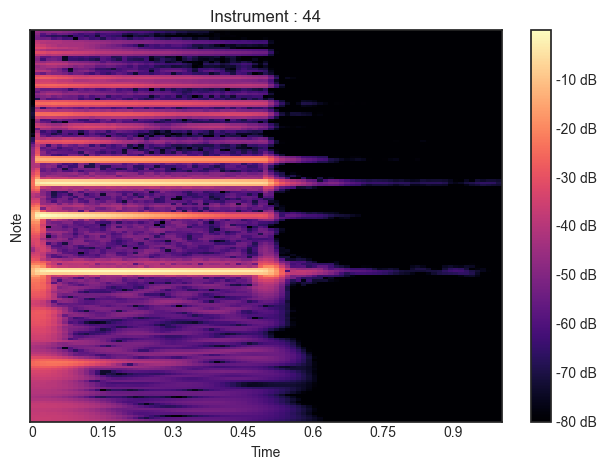

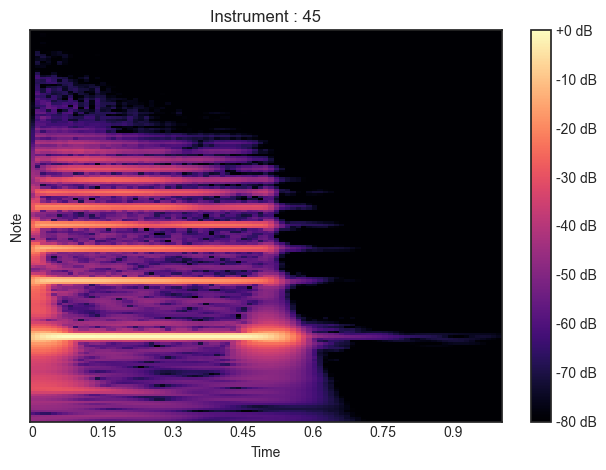

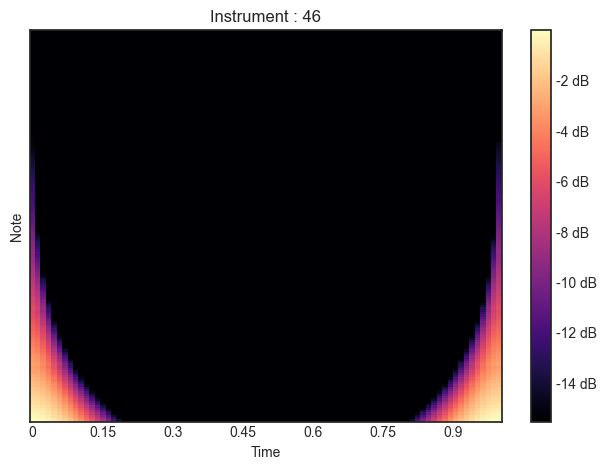

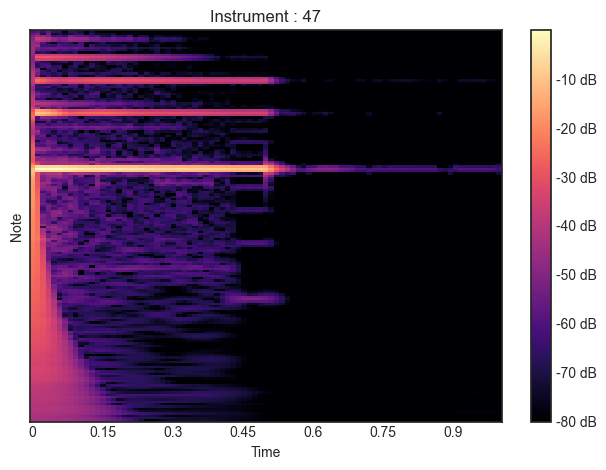

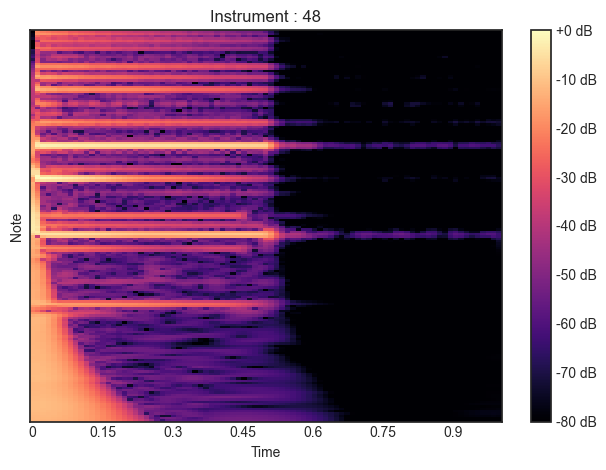

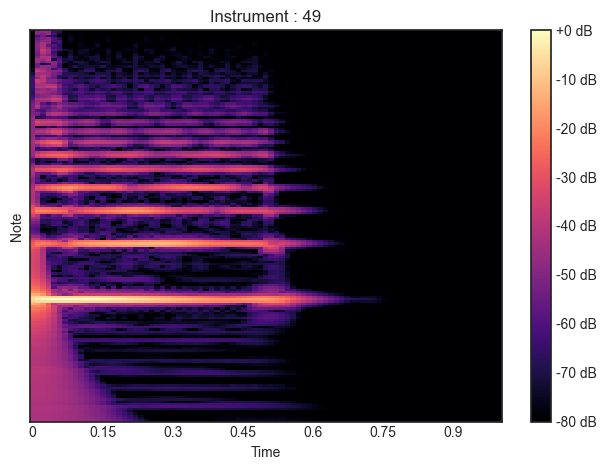

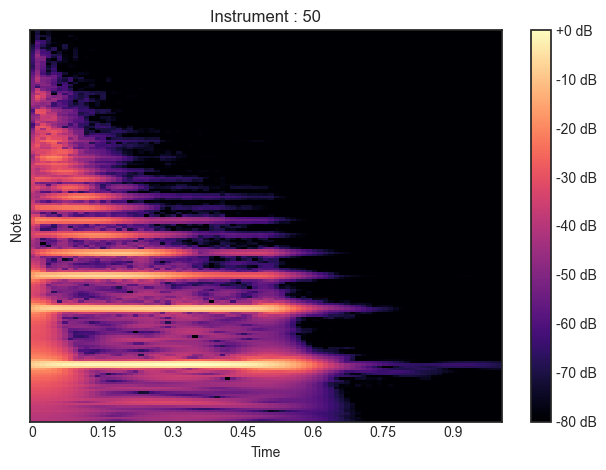

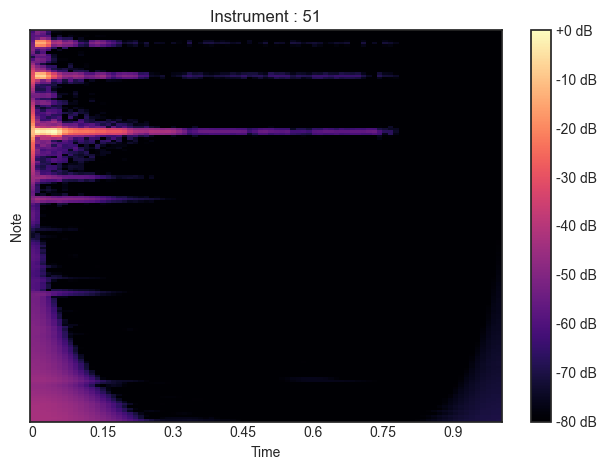

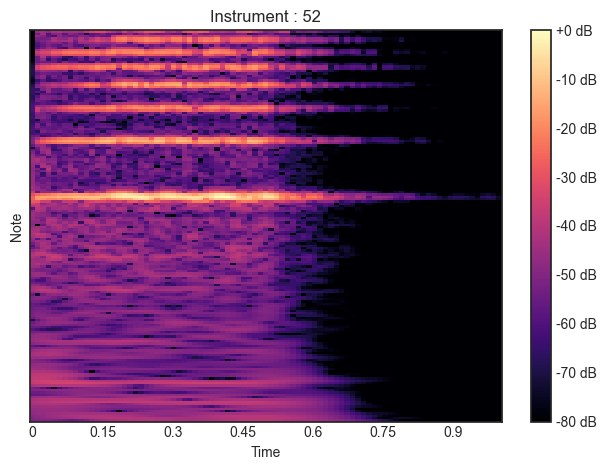

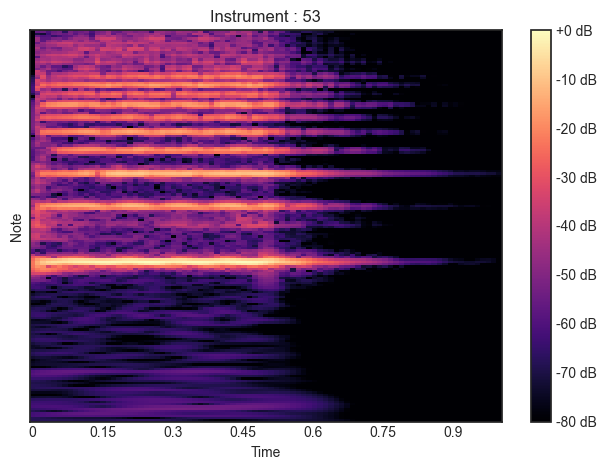

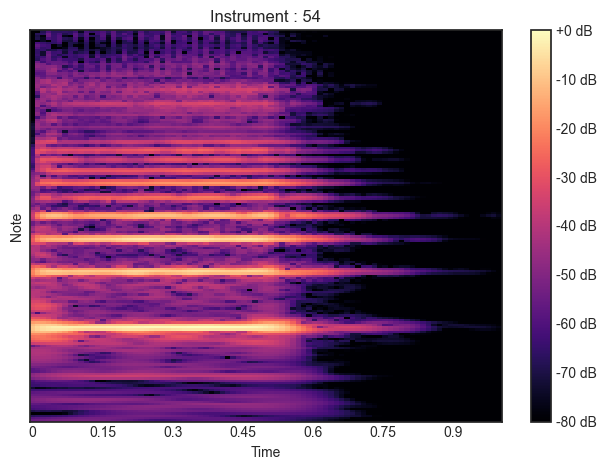

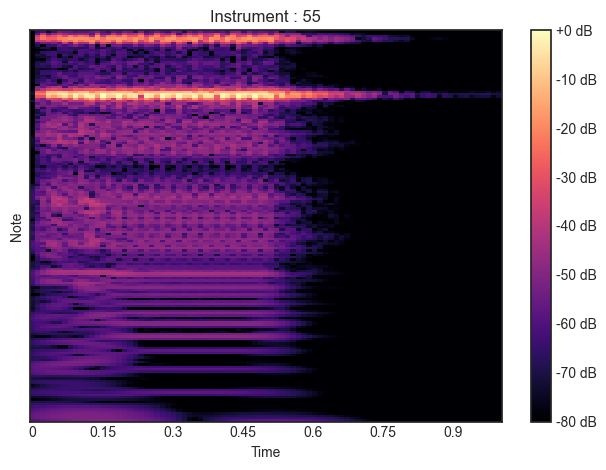

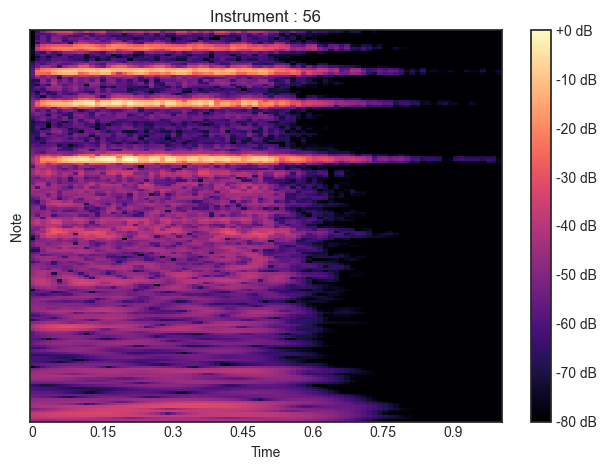

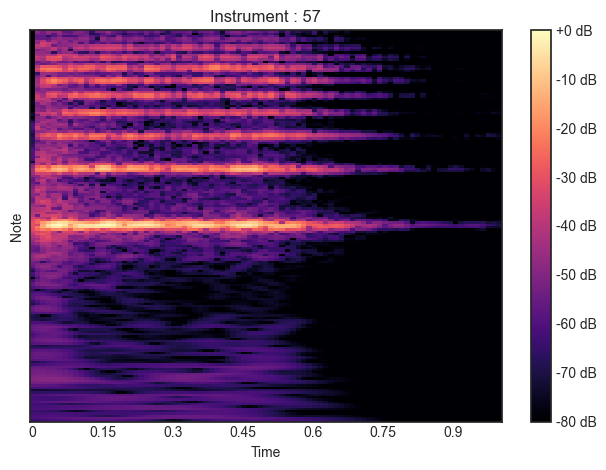

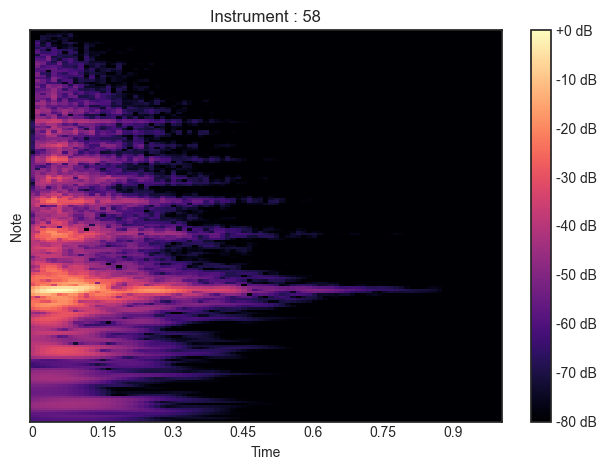

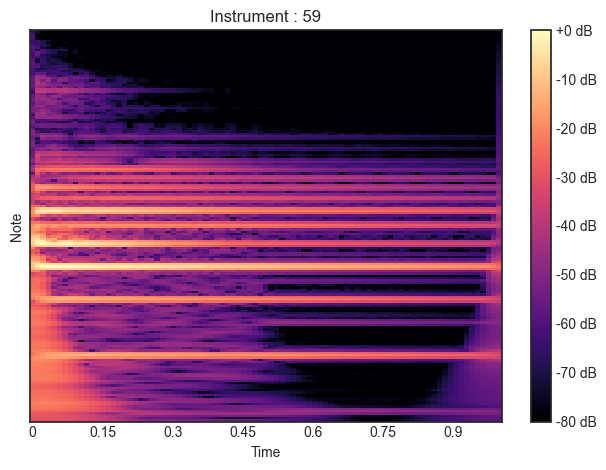

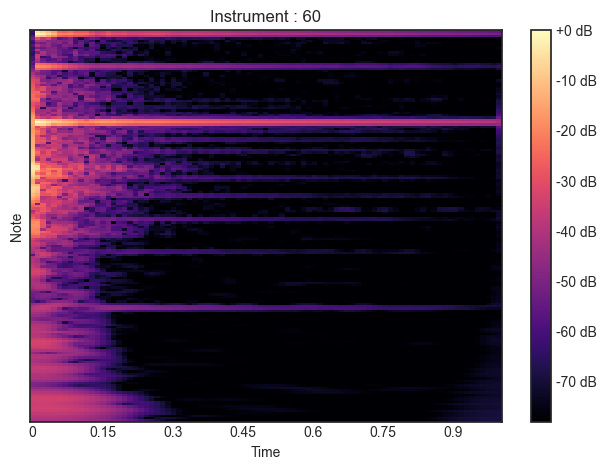

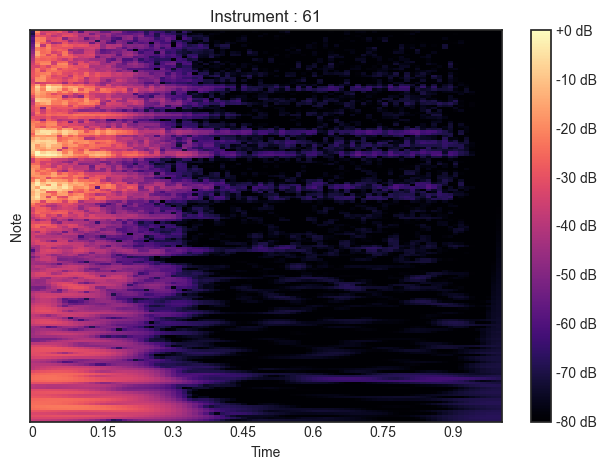

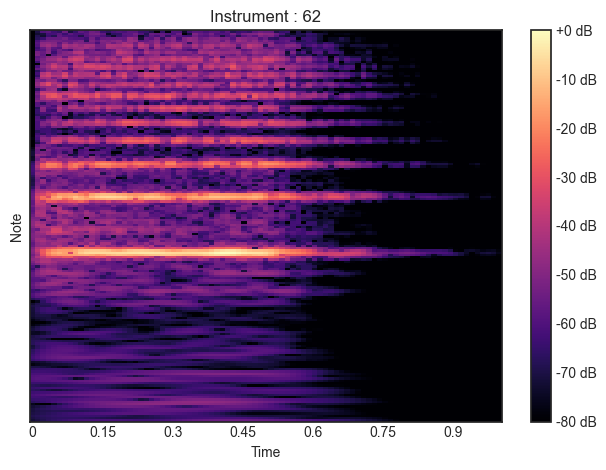

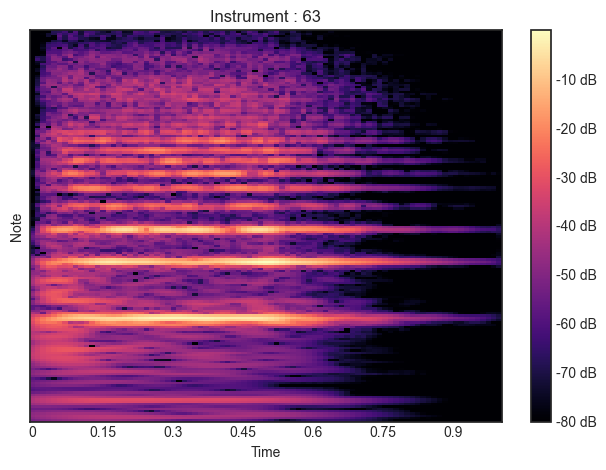

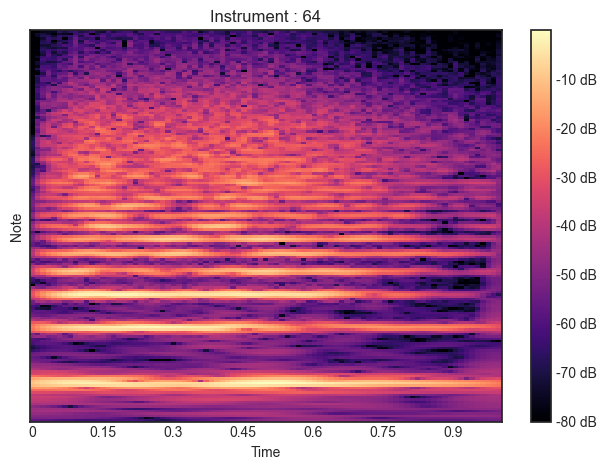

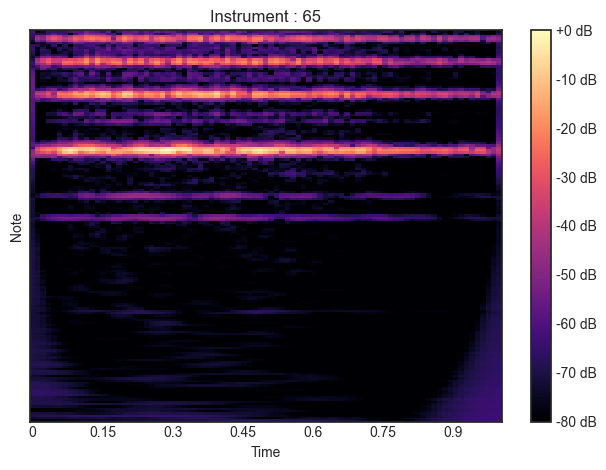

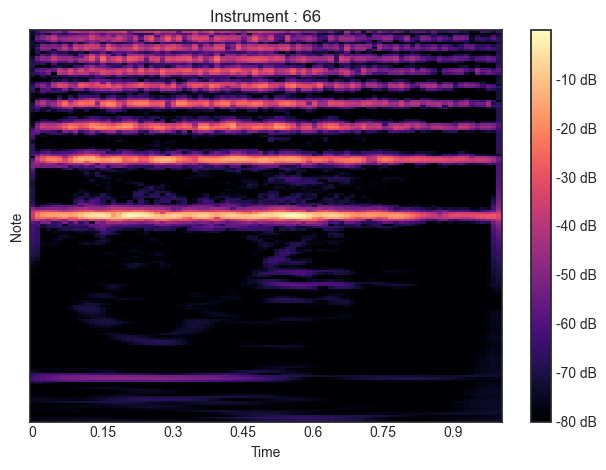

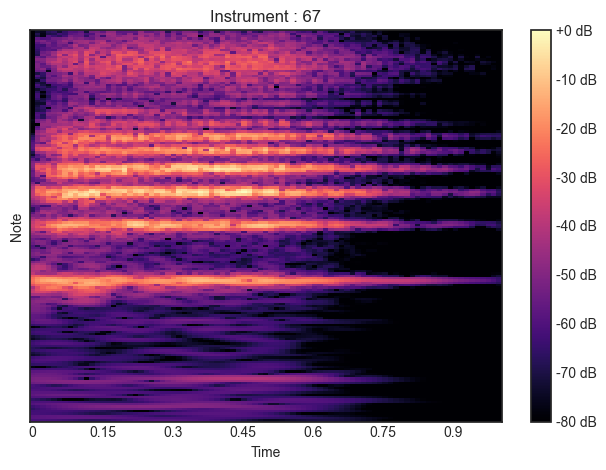

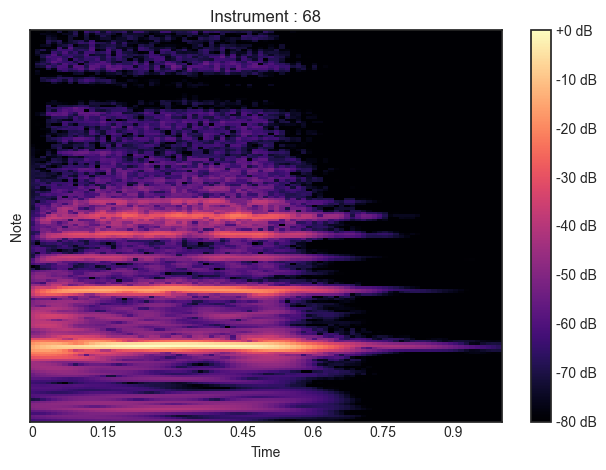

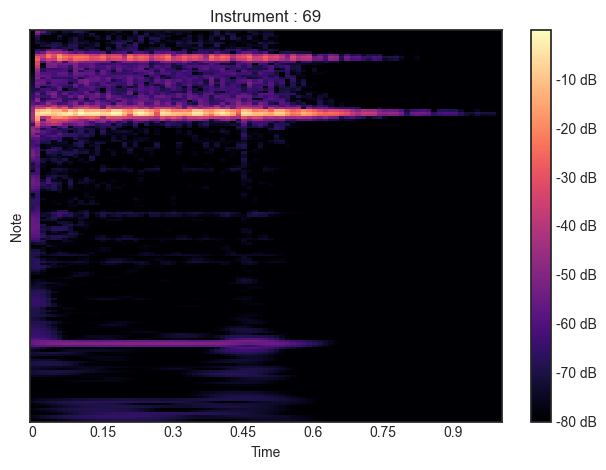

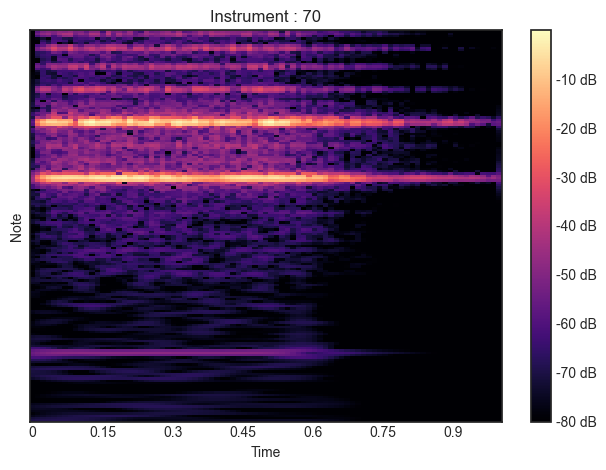

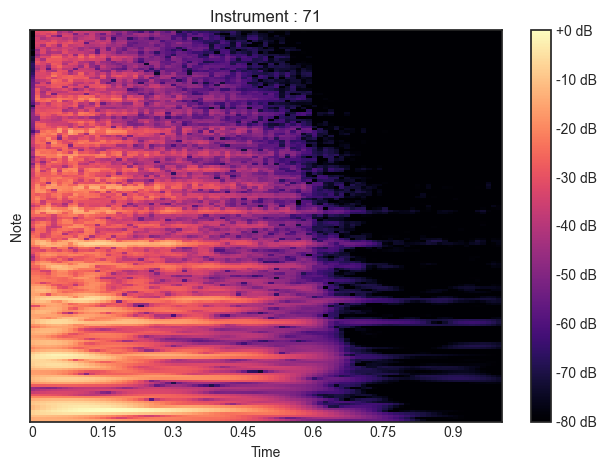

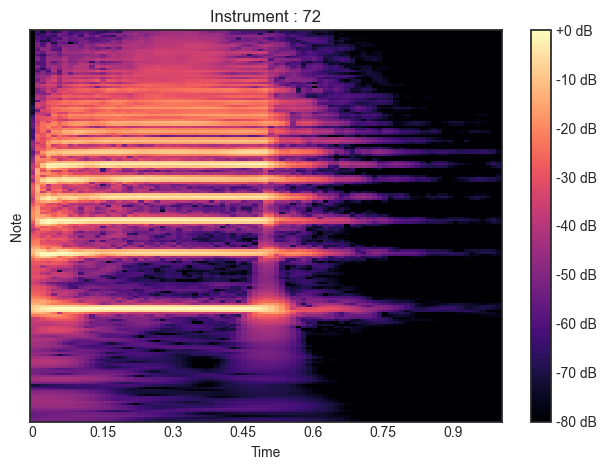

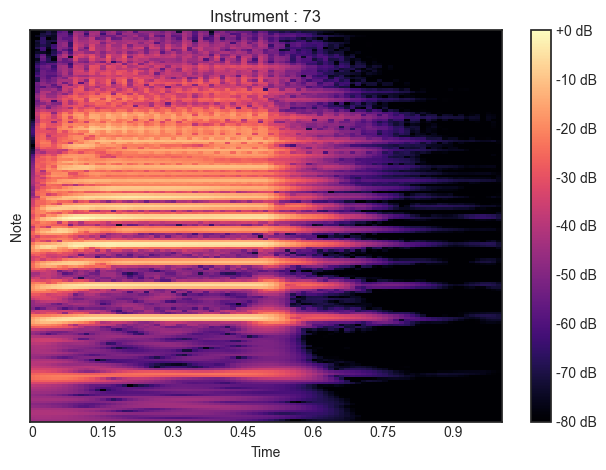

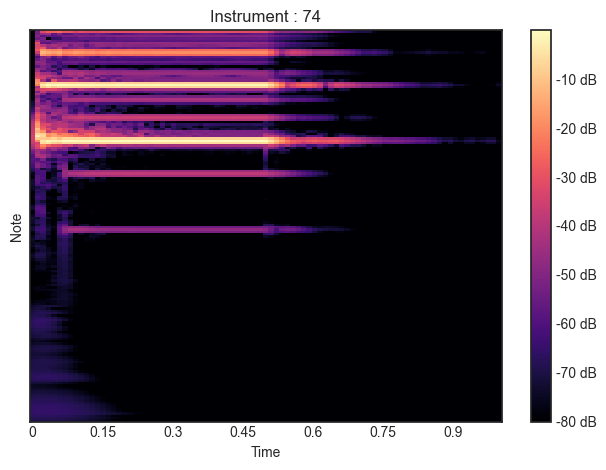

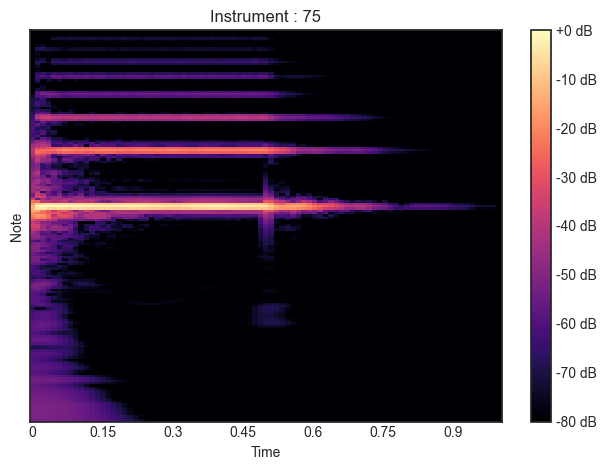

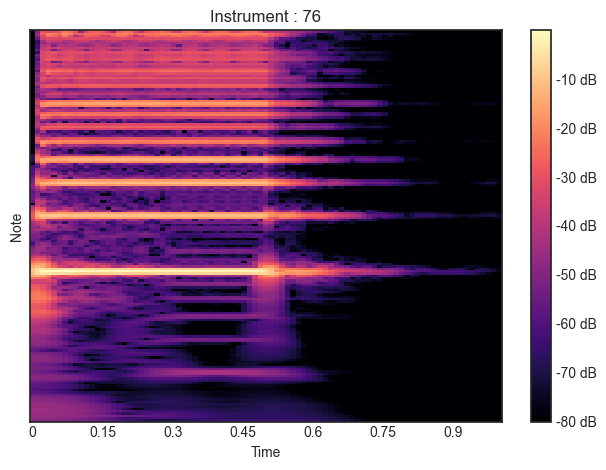

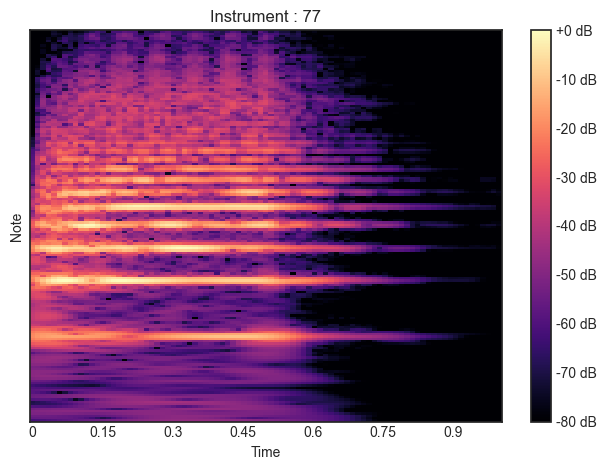

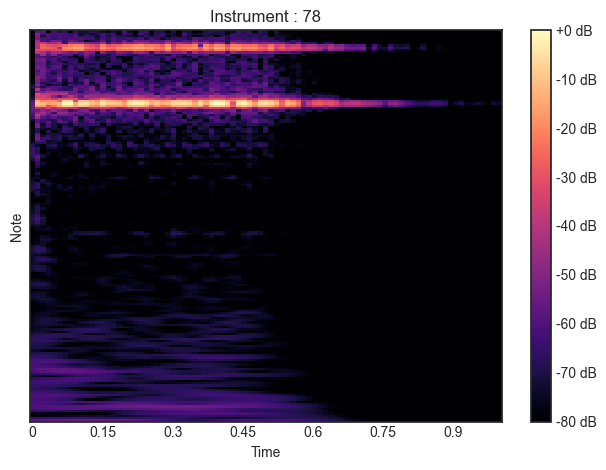

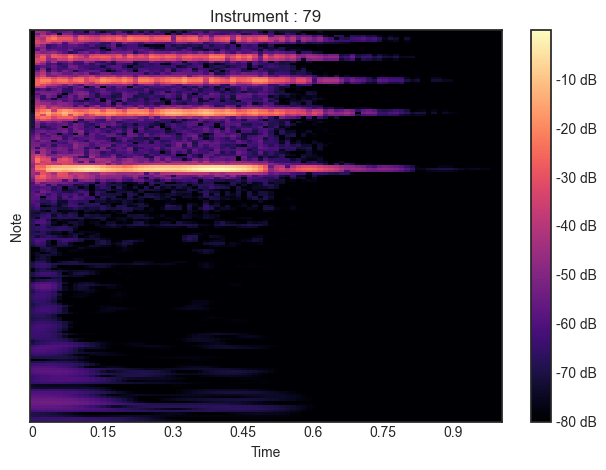

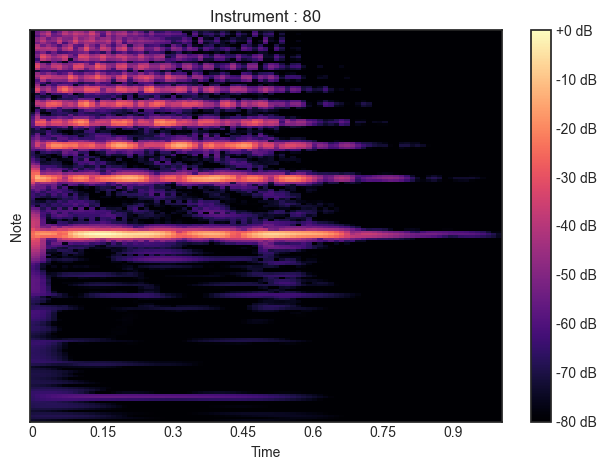

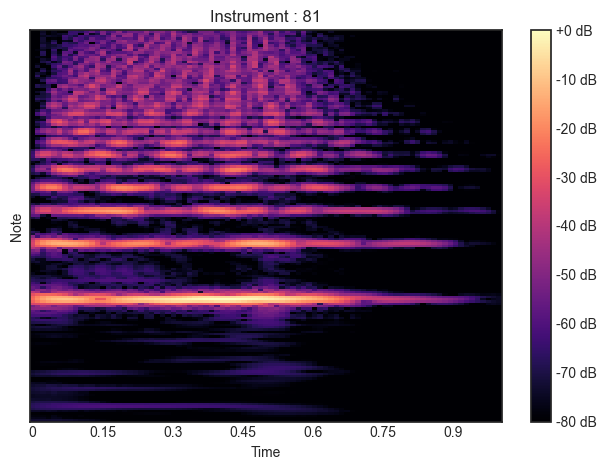

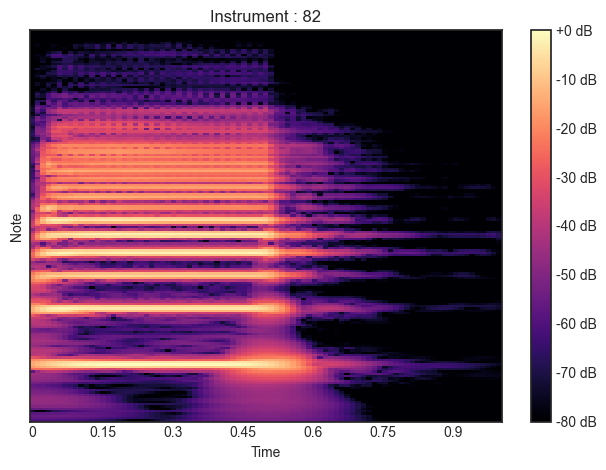

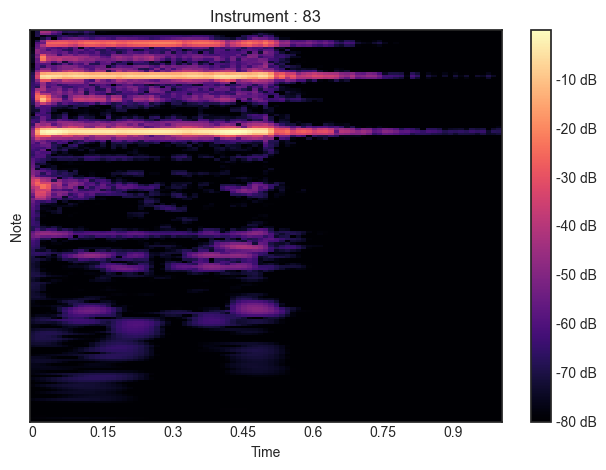

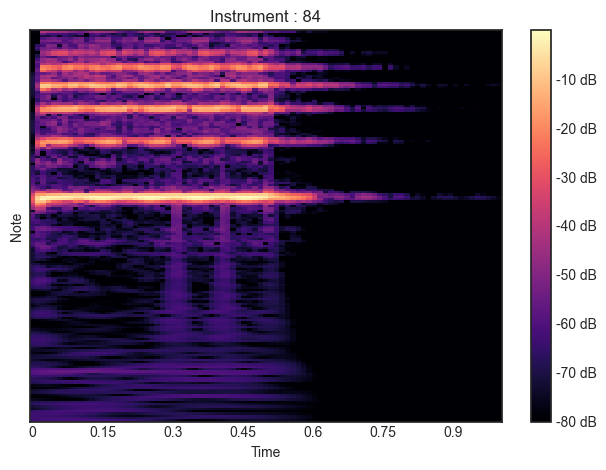

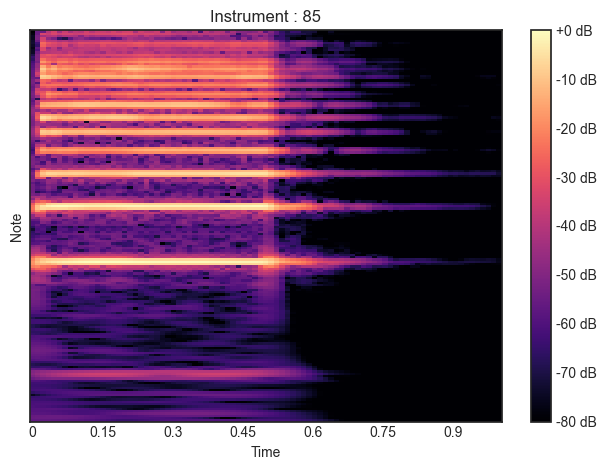

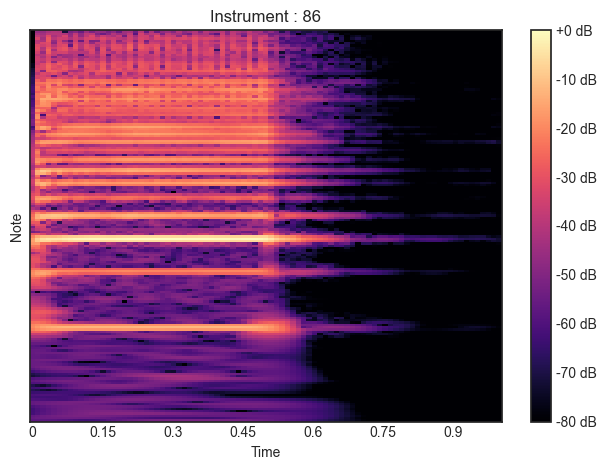

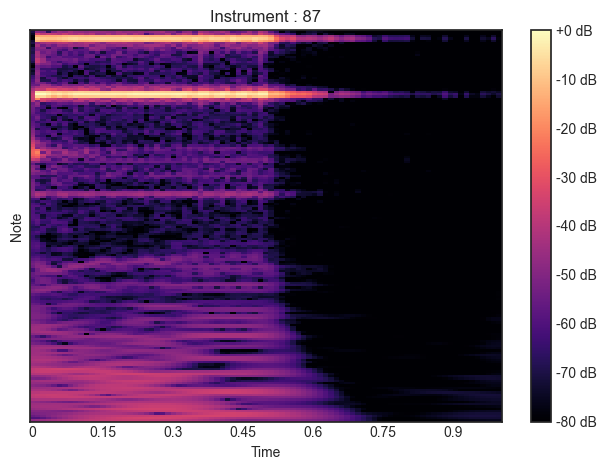

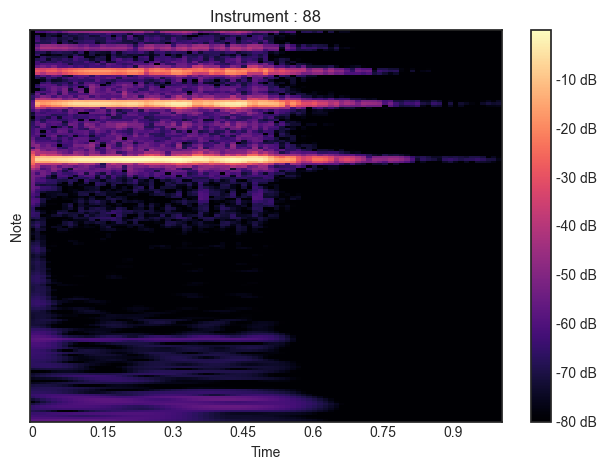

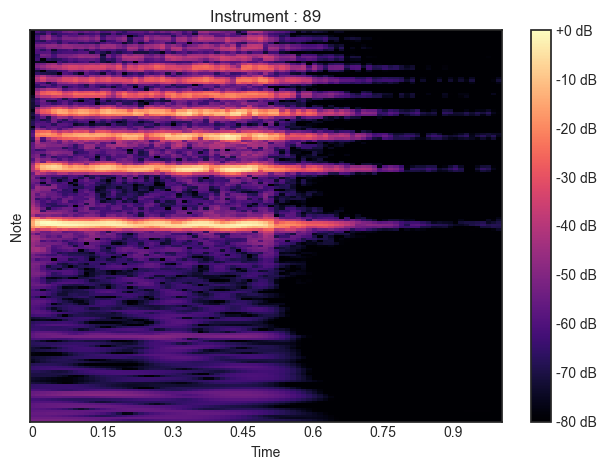

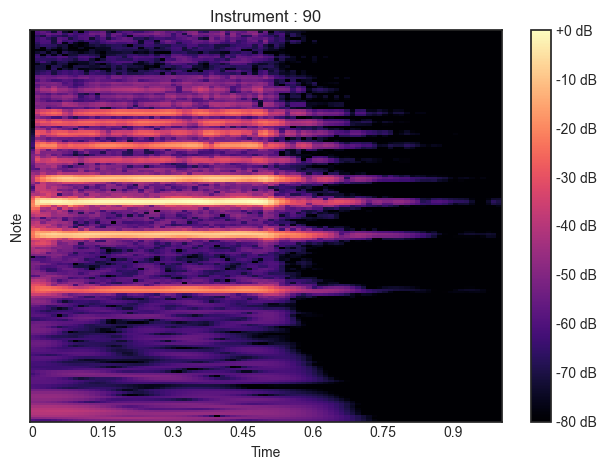

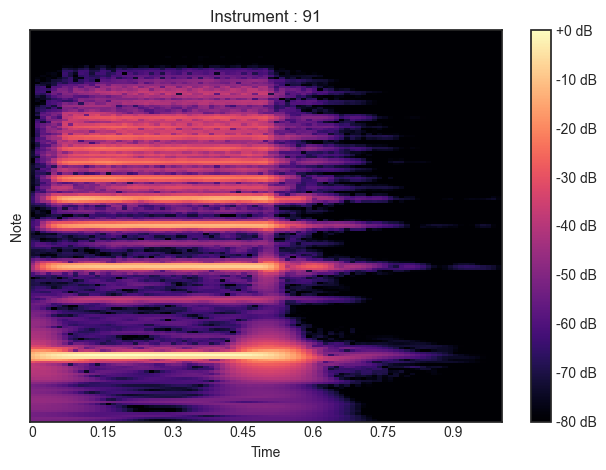

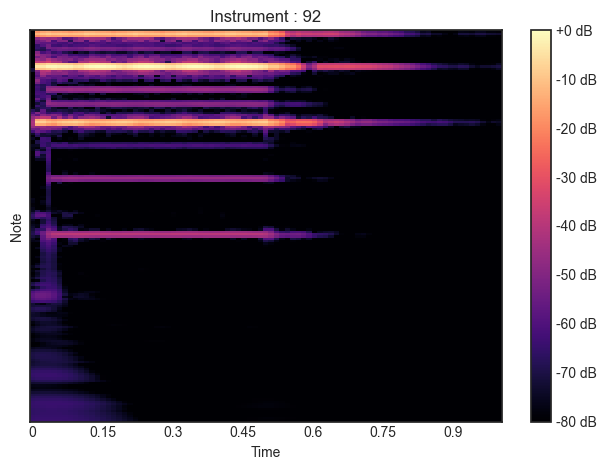

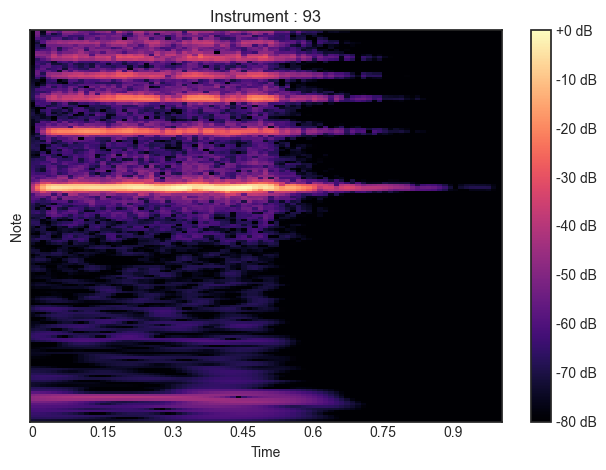

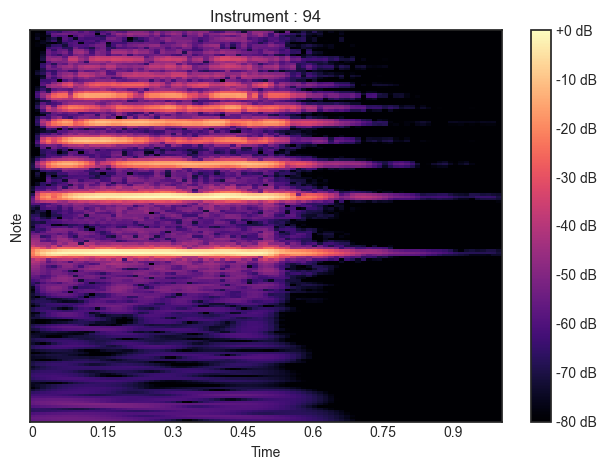

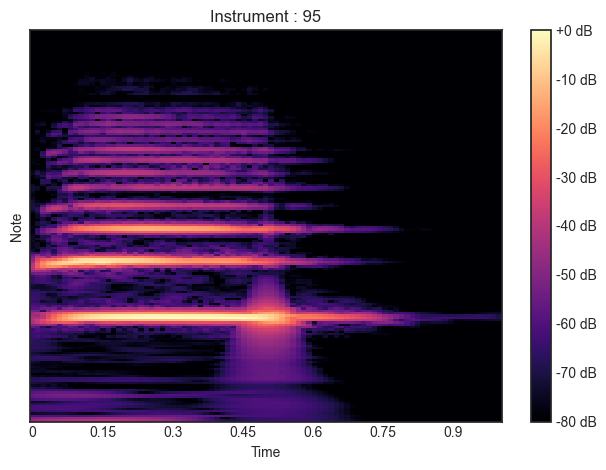

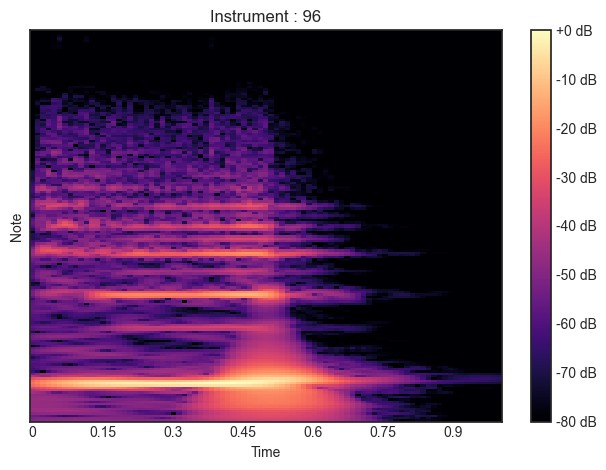

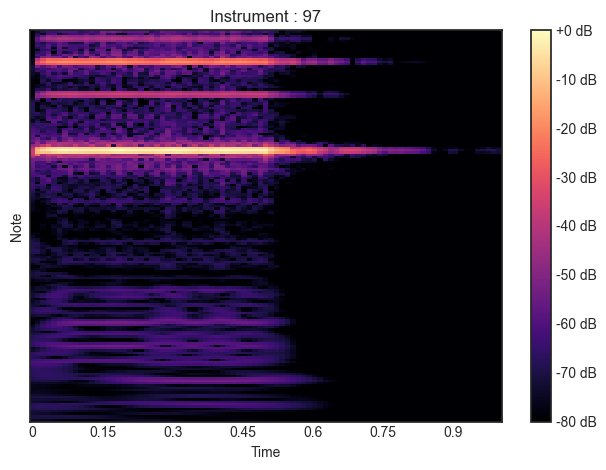

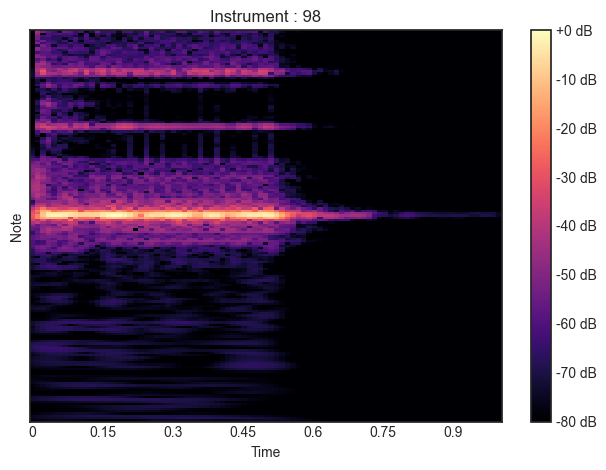

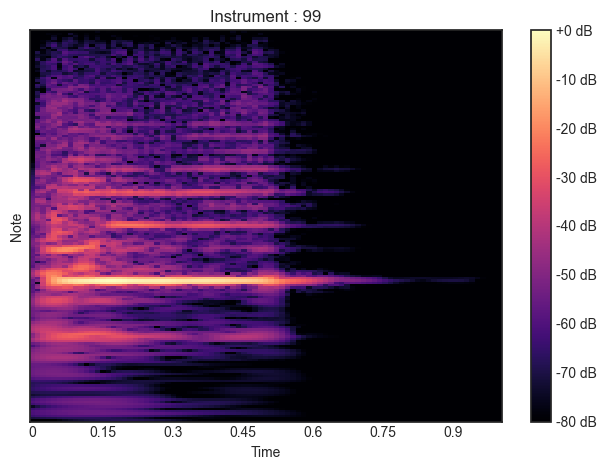

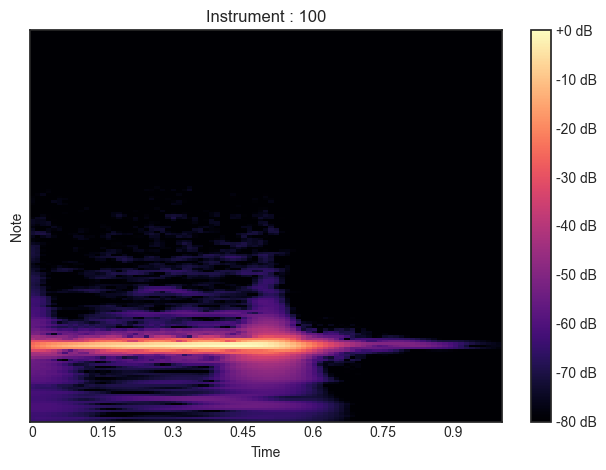

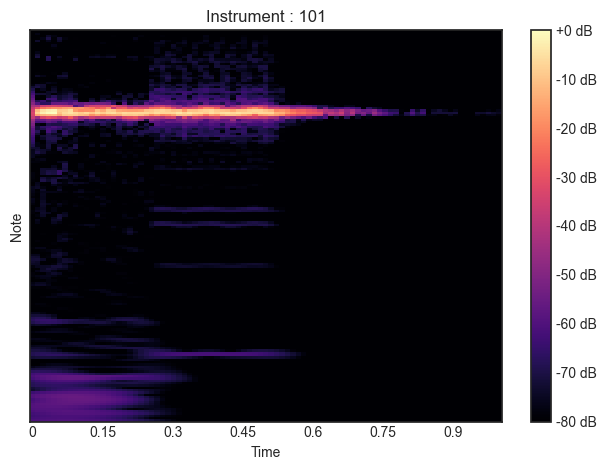

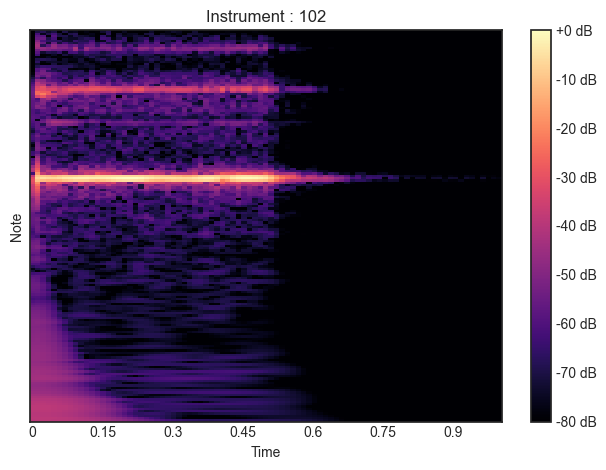

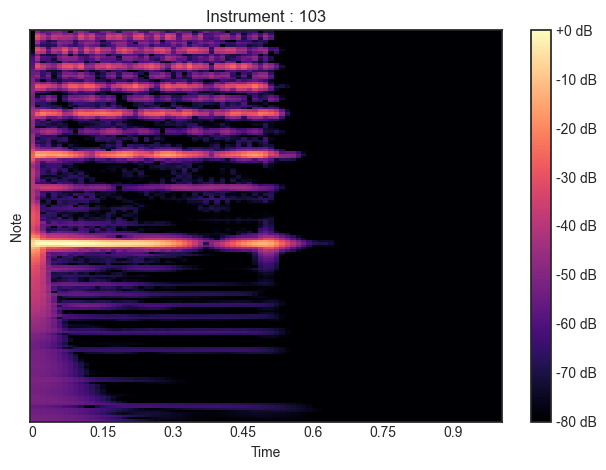

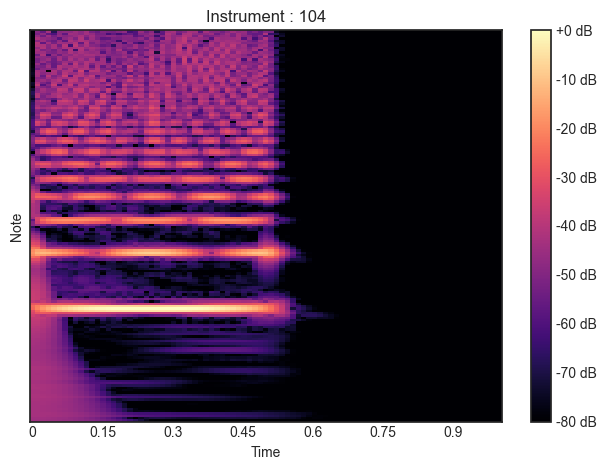

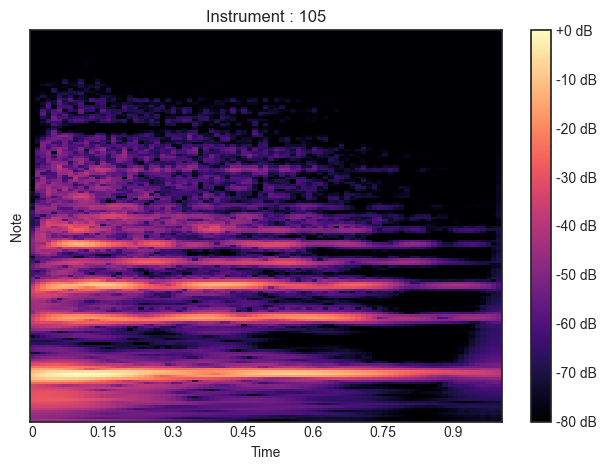

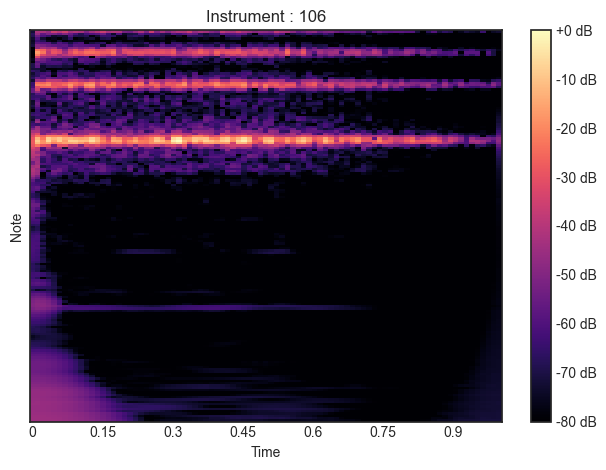

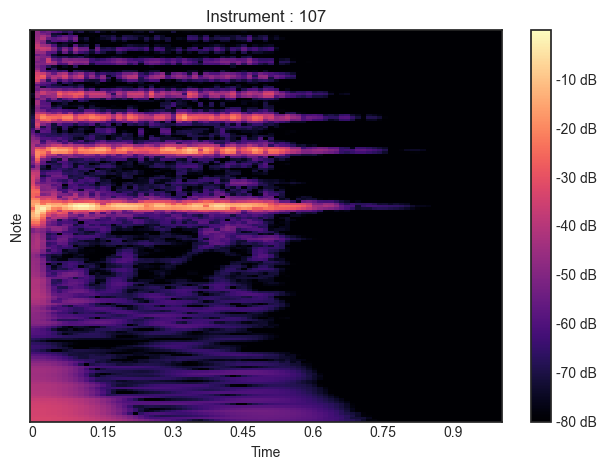

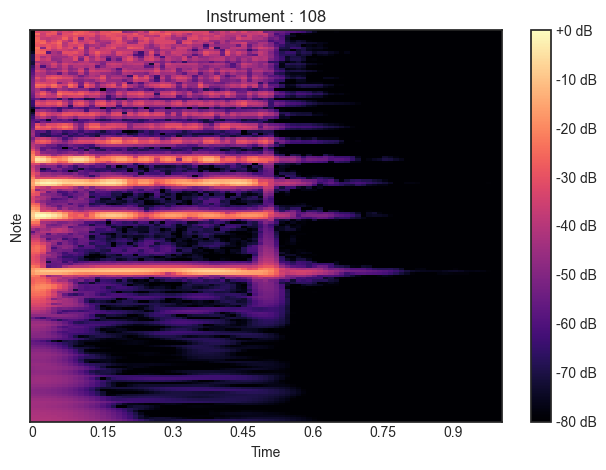

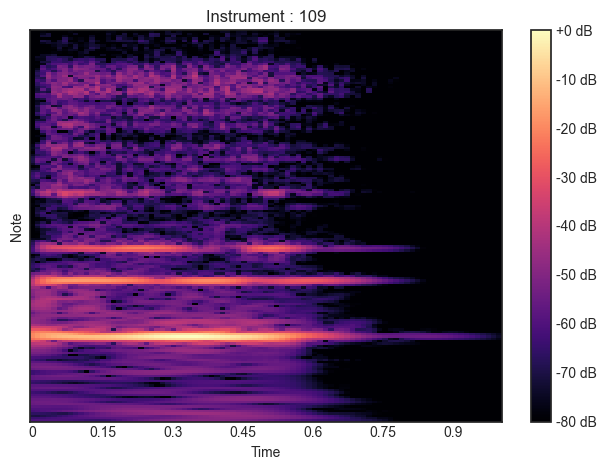

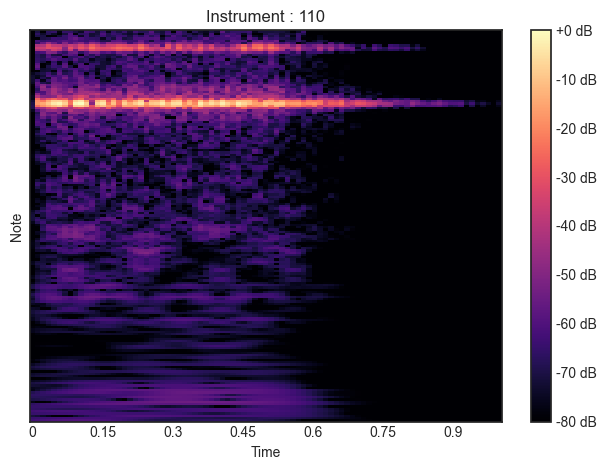

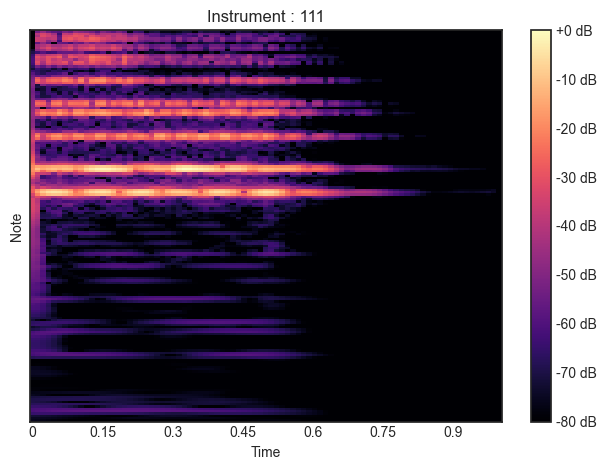

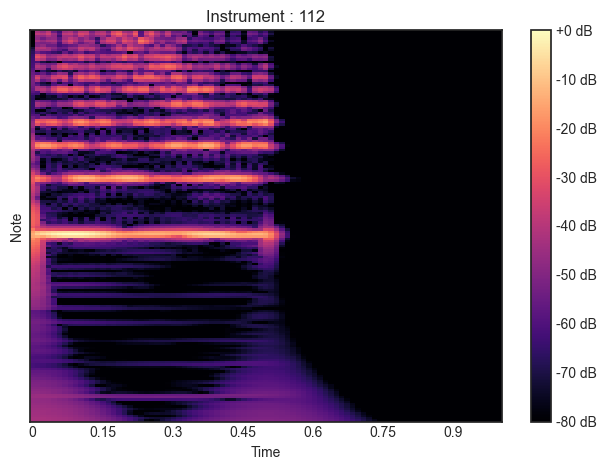

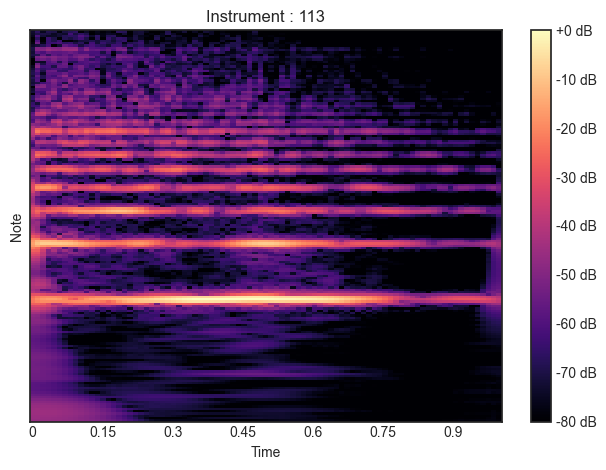

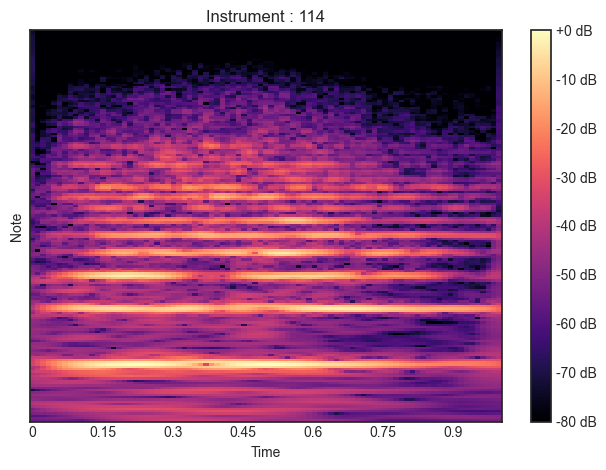

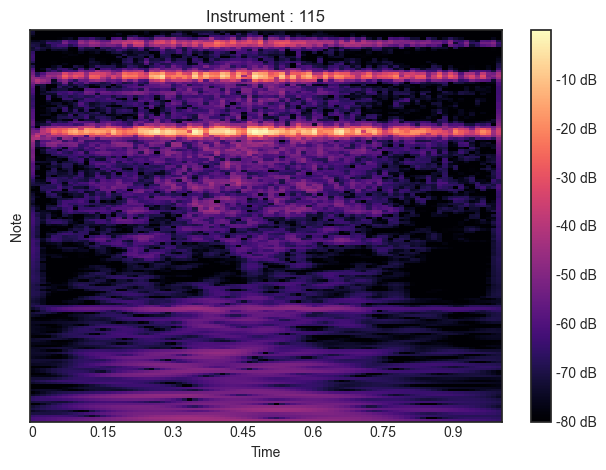

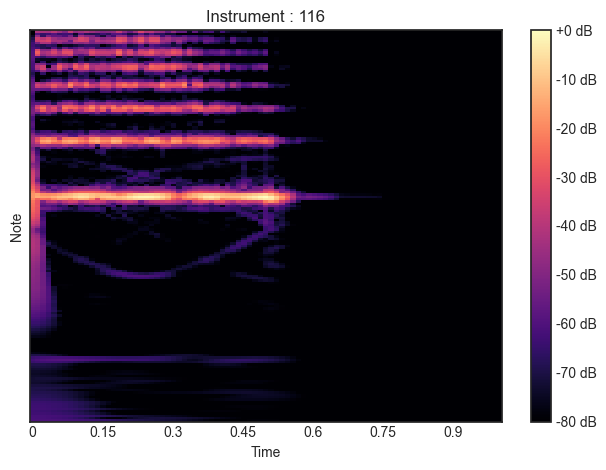

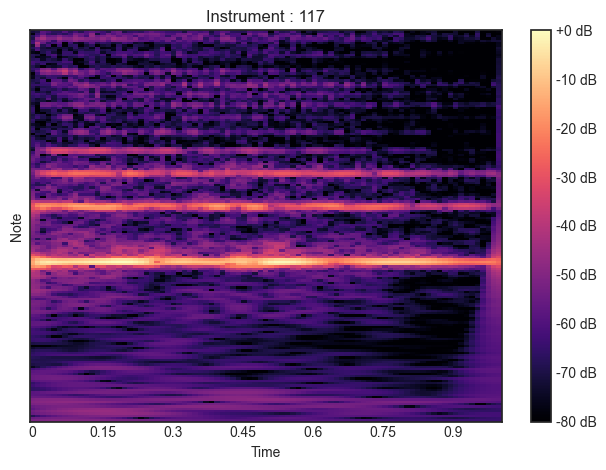

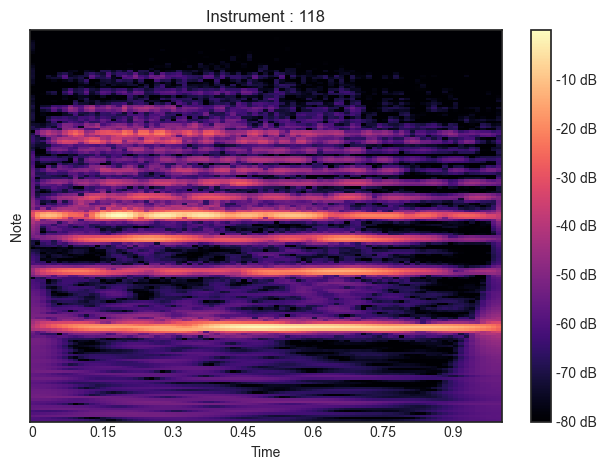

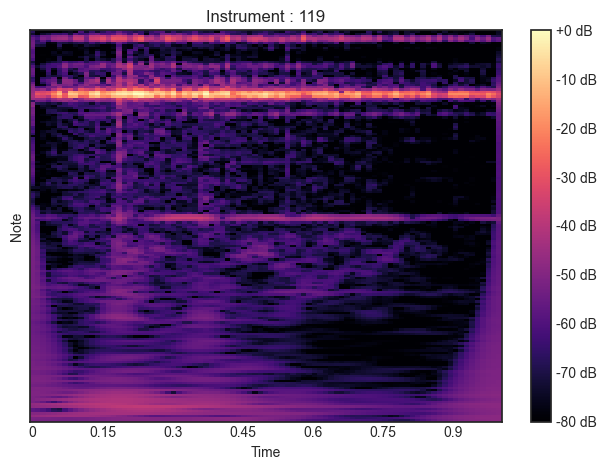

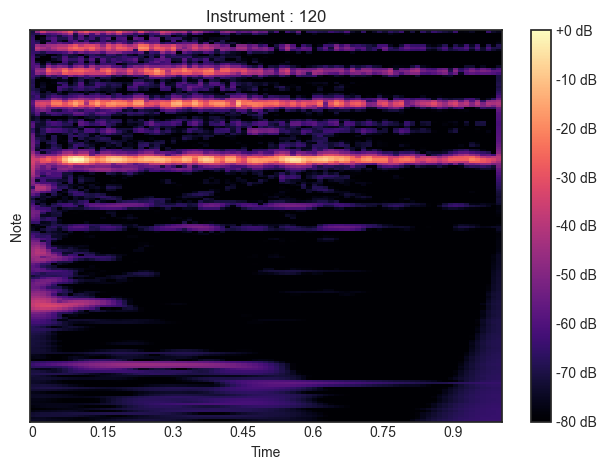

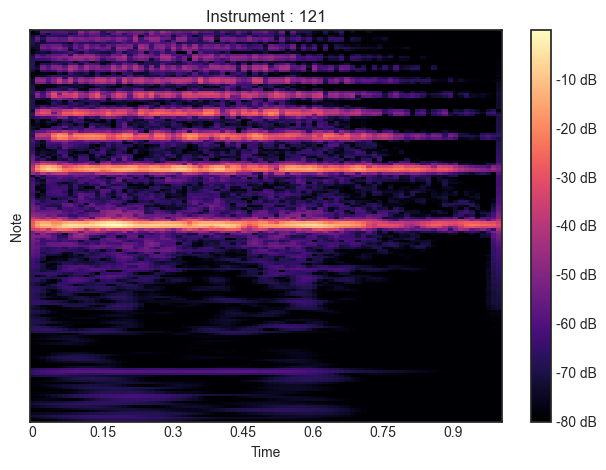

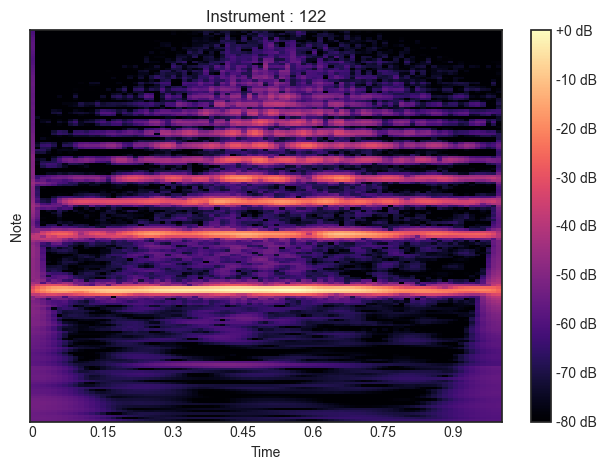

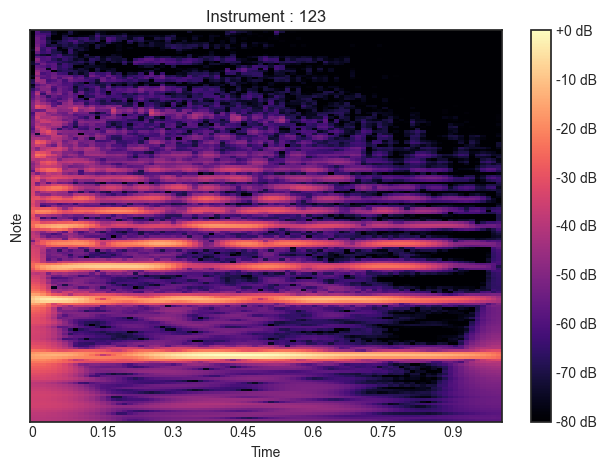

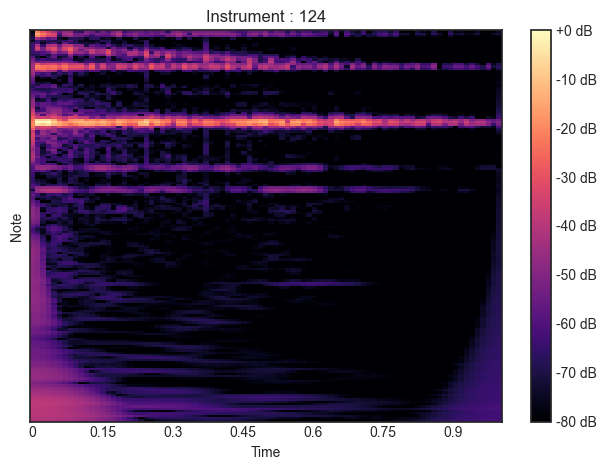

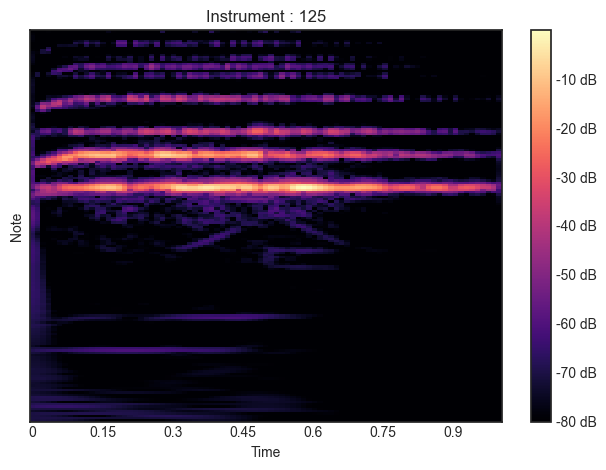

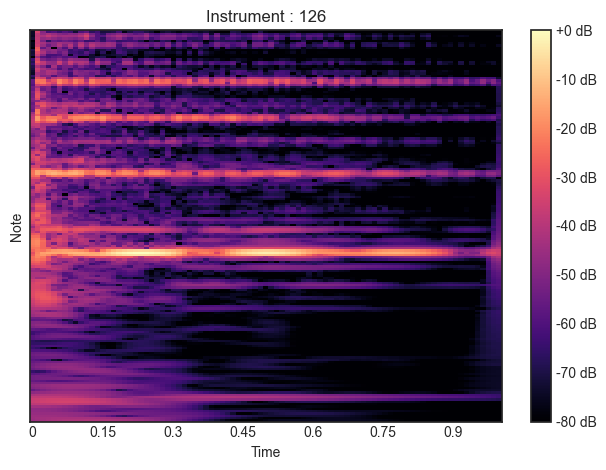

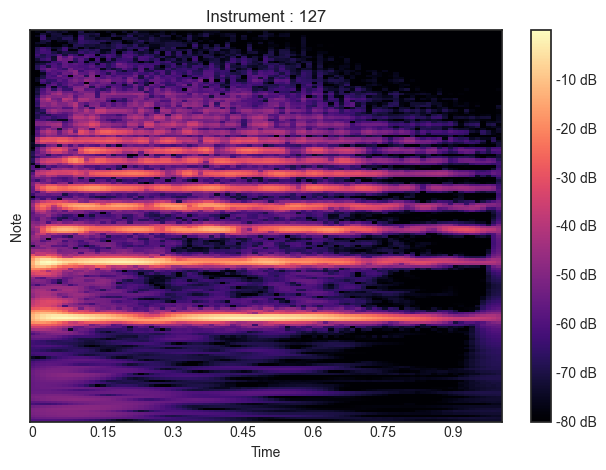

In [20]:
"""
- 주파수 대역을 spectogram으로 시각화
- 악기간 spectogram을 비교하여 차이 확인
"""
for idx in range(0, 128*num_notes, num_notes):
    amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[idx]), ref=np.max)
    librosa.display.specshow(data=amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Instrument : {inst[idx]}')
    plt.tight_layout()
    plt.show()

In [22]:
# Data split
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(6400, 168, 87) (6400,)


In [25]:
# Reshape 3d array to 2d array
cqt_np = cqt_np.reshape(6400, 168 * 87)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()